In [126]:
import yaml
import mysql.connector
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import squarify
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import folium

import scipy.stats as stats
from scipy.stats import ks_2samp
from scipy.stats import kstest, norm
from scipy.stats import levene
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests



import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [2]:
# Load the YAML file
with open("D:\Telangana_Growth_Analysis\db_config.yaml", 'r') as file:
    db_config = yaml.safe_load(file)

# Connect to the database
connection = mysql.connector.connect(**db_config)
cursor = connection.cursor()

![Image](https://drive.google.com/uc?export=download&id=1FDWY3xNgo3ounB-QJaQazWJloBqTKd0B)


### EDA

In [3]:
# SQL query to join 'fact_stamps' and 'dim_districts' on 'dist_code'

query = """
    select * from documents
    inner join districts on documents.dist_code = districts.dist_code
    """
# Use pandas to run the query and store the result in a DataFrame
stamps = pd.read_sql(query, connection)

# Sort the DataFrame by the 'id' column in ascending order
stamps.sort_values(by='id', ascending=True, inplace=True)
stamps.reset_index(drop=True, inplace=True)


# Load the 'dim_date' table into a DataFrame
dim_date = pd.read_sql("SELECT * FROM dim_date", connection)

# Merge the 'stamps' DataFrame with the 'dim_date' DataFrame on the 'month' column
stamps = pd.merge(stamps, dim_date, on='month', how='inner')
# Display the first few rows of the merged DataFrame
stamps.head()

,id,dist_code,month,documents_registered_cnt,documents_registered_rev,estamps_challans_cnt,estamps_challans_rev,dist_code,district,mmm,quarter,fiscal_year
0,1,14_1,2019-04-01,4533,59236363.0,0,0.0,14_1,Mahabubnagar\r,Apr,Q1,2019
1,2,17_3,2019-04-01,4151,41508762.0,0,0.0,17_3,Siddipet\r,Apr,Q1,2019
2,3,20_3,2019-04-01,2116,23674170.0,0,0.0,20_3,Rajanna Sircilla\r,Apr,Q1,2019
3,4,21_5,2019-04-01,1089,15915285.0,0,0.0,21_5,Mahabubabad\r,Apr,Q1,2019
4,5,23_1,2019-04-01,6133,82593256.0,0,0.0,23_1,Nalgonda\r,Apr,Q1,2019


In [4]:
#The \r is a carriage return character. 
# it can remove it from the district column using the str.replace method provided by pandas.

stamps['district'] = stamps['district'].str.replace('\r', '')

# drop dis_code
stamps.drop(columns=['dist_code','dist_code'], inplace=True)

stamps.head()

,id,month,documents_registered_cnt,documents_registered_rev,estamps_challans_cnt,estamps_challans_rev,district,mmm,quarter,fiscal_year
0,1,2019-04-01,4533,59236363.0,0,0.0,Mahabubnagar,Apr,Q1,2019
1,2,2019-04-01,4151,41508762.0,0,0.0,Siddipet,Apr,Q1,2019
2,3,2019-04-01,2116,23674170.0,0,0.0,Rajanna Sircilla,Apr,Q1,2019
3,4,2019-04-01,1089,15915285.0,0,0.0,Mahabubabad,Apr,Q1,2019
4,5,2019-04-01,6133,82593256.0,0,0.0,Nalgonda,Apr,Q1,2019


In [5]:
stamps.info() 
# No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504 entries, 0 to 1503
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1504 non-null   int64  
 1   month                     1504 non-null   object 
 2   documents_registered_cnt  1504 non-null   int64  
 3   documents_registered_rev  1504 non-null   float64
 4   estamps_challans_cnt      1504 non-null   int64  
 5   estamps_challans_rev      1504 non-null   float64
 6   district                  1504 non-null   object 
 7   mmm                       1504 non-null   object 
 8   quarter                   1504 non-null   object 
 9   fiscal_year               1504 non-null   int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 117.6+ KB


In [6]:
# change date to datetime type

stamps['month'] = pd.to_datetime(stamps['month'])

In [7]:
stamps.describe()

,id,month,documents_registered_cnt,documents_registered_rev,estamps_challans_cnt,estamps_challans_rev,fiscal_year
count,1504.000000,1504,1504.000000,1.504000e+03,1504.000000,1.504000e+03,1504.000000
mean,752.500000,2021-03-13 10:43:24.255319040,3238.007314,1.962961e+08,1944.861037,1.467299e+08,2020.489362
min,1.000000,2019-04-01 00:00:00,0.000000,0.000000e+00,0.000000,0.000000e+00,2019.000000
25%,376.750000,2020-03-01 00:00:00,1013.500000,1.840655e+07,0.000000,0.000000e+00,2019.000000
50%,752.500000,2021-03-01 00:00:00,1964.500000,3.512241e+07,805.000000,1.799040e+07,2020.000000
75%,1128.250000,2022-04-01 00:00:00,3952.500000,9.339799e+07,2198.000000,5.299411e+07,2022.000000
max,1504.000000,2023-03-01 00:00:00,31310.000000,4.073496e+09,30526.000000,4.294273e+09,2022.000000
std,434.311716,NaN,4196.002256,5.224591e+08,3740.305328,4.963718e+08,1.127834


from above observed that documents_registered_cnt has min 0, lets dig deeper

In [8]:
grouped_data = stamps.groupby('month').agg({
    'documents_registered_cnt': 'sum',
    'documents_registered_rev': 'sum',
    'estamps_challans_cnt': 'sum',
    'estamps_challans_rev': 'sum'
}).reset_index()

# Function to plot individual columns with specified color
def plot_individual_column(column_name, title, color):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=grouped_data['month'], 
                             y=grouped_data[column_name], 
                             mode='lines+markers',
                             line=dict(color=color)))
    fig.update_layout(title=title,
                      xaxis_title='Month/Year',
                      yaxis_title='Value',
                      template="plotly_dark")
    fig.show()

# Plot for 'Documents Registered Count' in blue
plot_individual_column('documents_registered_cnt', 'Monthly Trends for Documents Registered Count', 'blue')

# Plot for 'Documents Registered Revenue' in green
plot_individual_column('documents_registered_rev', 'Monthly Trends for Documents Registered Revenue', 'green')

# Plot for 'E-stamps Challans Count' in red
plot_individual_column('estamps_challans_cnt', 'Monthly Trends for E-stamps Challans Count', 'red')

# Plot for 'E-stamps Challans Revenue' in purple
plot_individual_column('estamps_challans_rev', 'Monthly Trends for E-stamps Challans Revenue', 'purple')


## Problem Statement 1 
## 1. How does the revenue generated from document registration vary across districts in Telangana? List down the top 5 districts that showed the highest document registration revenue growth between FY 2019 and 2022.

#### Revenue Analysis Across Districts
To understand how the revenue from document registration varies across districts, we can group the data by district and sum the documents_registered_rev.

In [9]:
districts_revenue = stamps.groupby('district')['documents_registered_rev'].sum().reset_index()

# Sort the dataframe from highest to lowest revenue
districts_revenue = districts_revenue.sort_values(by='documents_registered_rev', ascending=False)

districts_revenue.head(50)

,district,documents_registered_rev
24,Rangareddy,1.081987e+11
15,Medchal_Malkajgiri,6.407138e+10
3,Hyderabad,3.839674e+10
25,Sangareddy,2.202450e+10
2,Hanumakonda,7.927494e+09
31,Yadadri Bhuvanagiri,5.973745e+09
9,Khammam,5.606142e+09
18,Nalgonda,4.521634e+09
21,Nizamabad,4.046937e+09
8,Karimnagar,4.024475e+09


In [10]:
# Convert Revenue to Millions
#districts_revenue['documents_registered_rev'] = districts_revenue['documents_registered_rev'] / 1e6  # Convert to millions

fig = px.bar(districts_revenue, 
             x='documents_registered_rev', 
             y='district', 
             orientation='h', 
             title='Revenue from Document Registration by District (in Millions)',
             labels={'documents_registered_rev': 'Revenue (in Millions)', 'district': 'District'},
             color='district',  # Assigning color based on district
             color_discrete_sequence=px.colors.qualitative.Set1  # Using a color palette
            )  # Display district names on bars

# Remove legend and adjust vertical size
fig.update_layout(showlegend=False, height=1000)

fig.show()

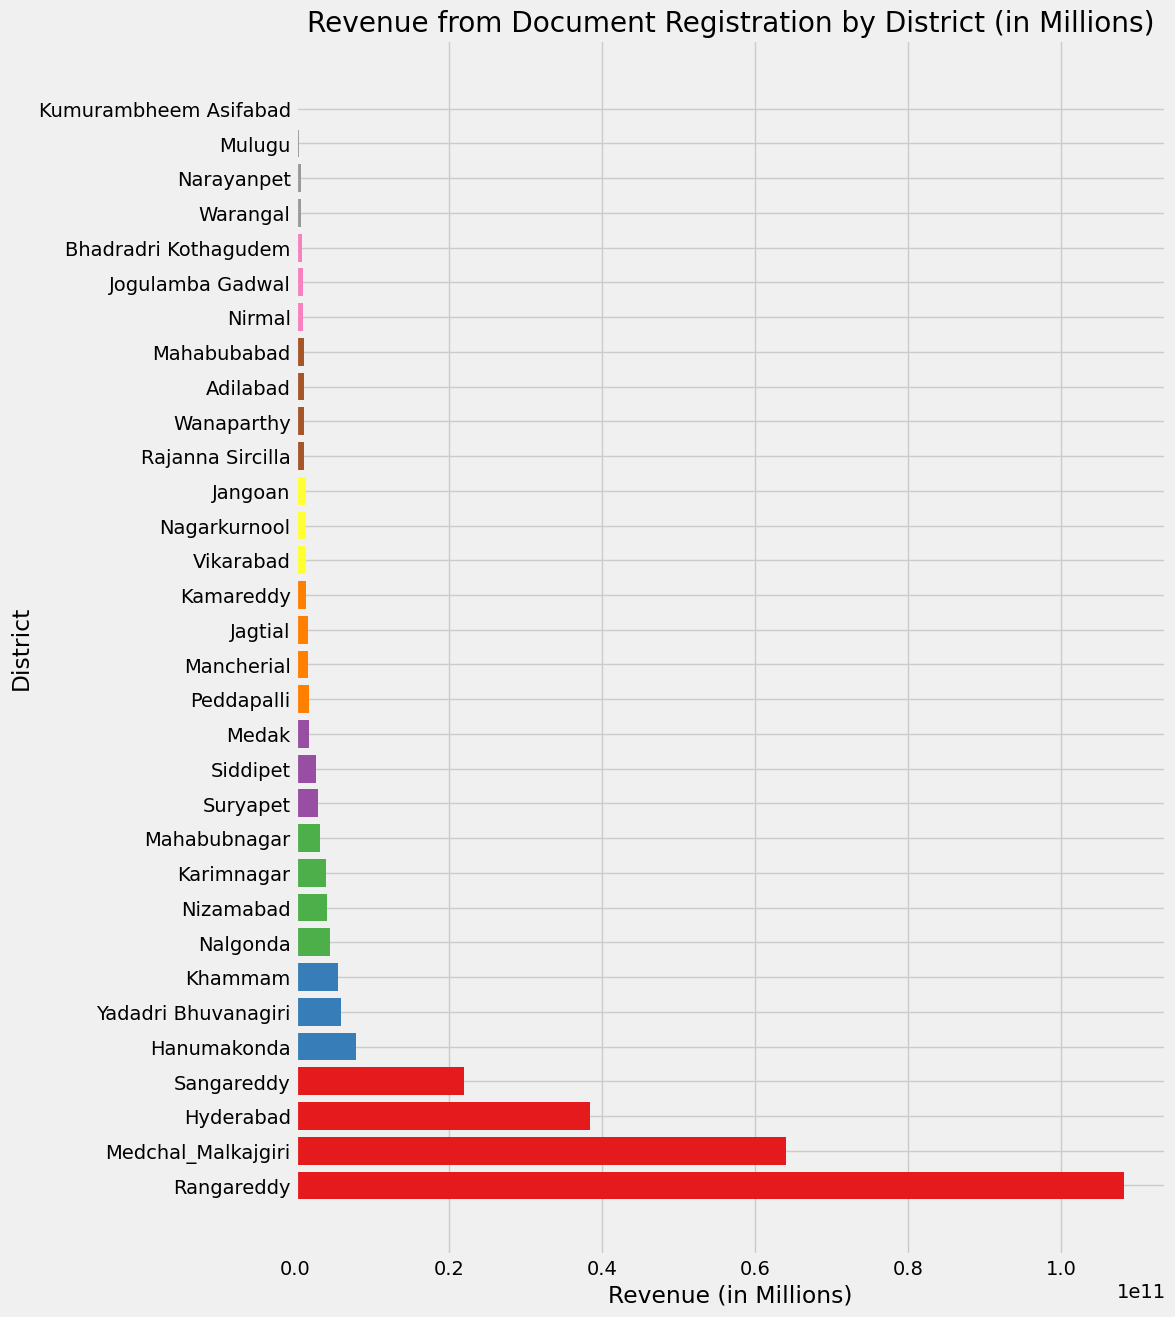

In [11]:
# Set the color palette
colors = plt.cm.Set1(np.linspace(0, 1, len(districts_revenue)))

plt.figure(figsize=(10, 15))  # Adjust the figure size

# Create horizontal bar plot
bars = plt.barh(districts_revenue['district'], 
                districts_revenue['documents_registered_rev'], 
                color=colors)

# Set title and labels
plt.title('Revenue from Document Registration by District (in Millions)')
plt.xlabel('Revenue (in Millions)')
plt.ylabel('District')

# Display the plot
plt.show()

### Calculate Revenue Growth

To calculate the revenue growth between FY 2019 and FY 2022 for each district, follow these steps:

1. **Filter Data for FY 2019 and FY 2022:** Start by filtering the data to include only the financial data for the fiscal years 2019 and 2022.

2. **Calculate the Growth Rate:** Use the following formula to calculate the revenue growth rate:

$$
\text{Growth Rate} = \frac{\text{Revenue in 2022} - \text{Revenue in 2019}}{\text{Revenue in 2019}} \times 100
$$


In [12]:
stamps.head()

,id,month,documents_registered_cnt,documents_registered_rev,estamps_challans_cnt,estamps_challans_rev,district,mmm,quarter,fiscal_year
0,1,2019-04-01,4533,59236363.0,0,0.0,Mahabubnagar,Apr,Q1,2019
1,2,2019-04-01,4151,41508762.0,0,0.0,Siddipet,Apr,Q1,2019
2,3,2019-04-01,2116,23674170.0,0,0.0,Rajanna Sircilla,Apr,Q1,2019
3,4,2019-04-01,1089,15915285.0,0,0.0,Mahabubabad,Apr,Q1,2019
4,5,2019-04-01,6133,82593256.0,0,0.0,Nalgonda,Apr,Q1,2019


In [13]:
# Filter data for FY 2019 and FY 2022
revenue_2019 = stamps[stamps['fiscal_year'] == 2019].groupby('district')['documents_registered_rev'].sum().reset_index()
revenue_2019.columns = ['district', 'documents_registered_rev_2019']

revenue_2022 = stamps[stamps['fiscal_year'] == 2022].groupby('district')['documents_registered_rev'].sum().reset_index()
revenue_2022.columns = ['district', 'documents_registered_rev_2022']

# Merge the two dataframes on 'district'
merged_revenue = revenue_2019.merge(revenue_2022, on='district')

# Calculate growth rate
merged_revenue['growth_rate'] = ((merged_revenue['documents_registered_rev_2022'] - merged_revenue['documents_registered_rev_2019']) / merged_revenue['documents_registered_rev_2019']) * 100

In [14]:
# Sort by growth rate and display top 5 districts
top_5_districts = merged_revenue.sort_values(by='growth_rate', ascending=False).head(5)
top_5_districts[['district', 'growth_rate']]

,district,growth_rate
16,Mulugu,170.937720
0,Adilabad,122.841346
8,Karimnagar,92.745530
13,Mancherial,91.749143
15,Medchal_Malkajgiri,91.684370


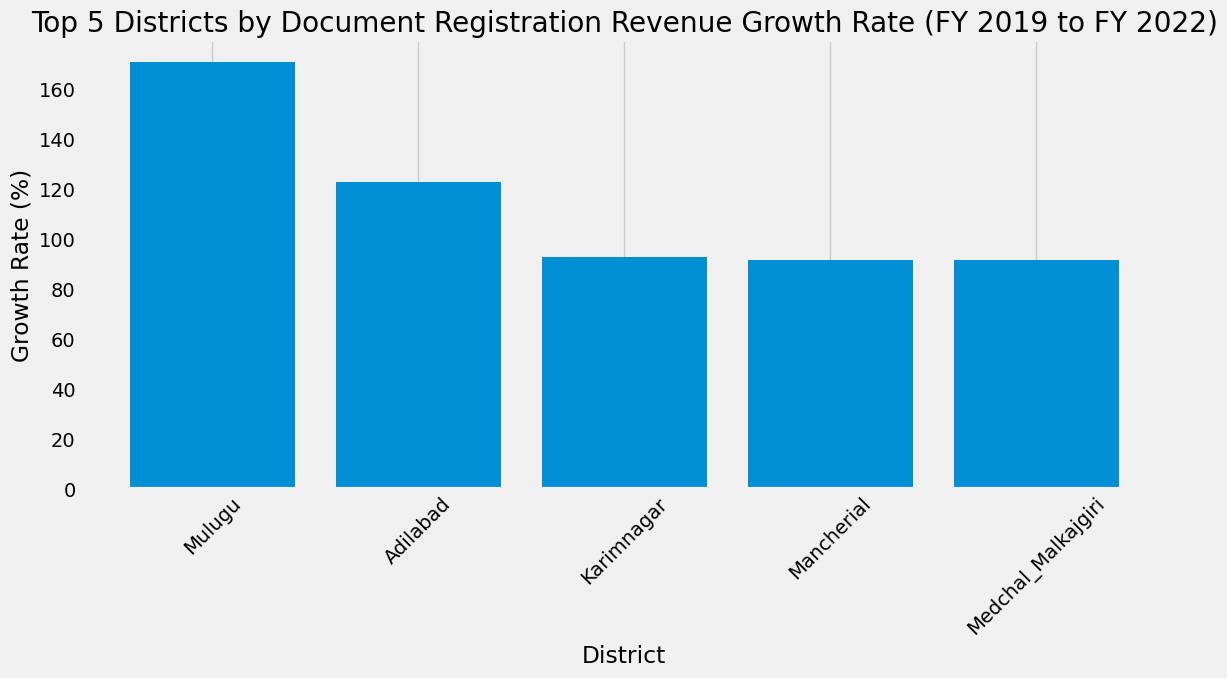

In [15]:
# Sort by growth rate and get top 5 districts
top_5_districts = merged_revenue.sort_values(by='growth_rate', ascending=False).head(5)

# Plotting
plt.figure(figsize=(12, 7))
plt.bar(top_5_districts['district'], top_5_districts['growth_rate'])
plt.xlabel('District')
plt.ylabel('Growth Rate (%)')
plt.title('Top 5 Districts by Document Registration Revenue Growth Rate (FY 2019 to FY 2022)')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()

## Executive Summary

The revenue generated from document registration in Telangana varies significantly across districts. This report provides insights into the revenue distribution across districts and highlights the top-performing and underperforming districts in terms of revenue generation and growth.

## Key Findings

### Top Revenue Generating Districts

- Rangareddy: This district tops the list with a staggering revenue of approximately ₹1,081.99 billion.
- Medchal_Malkajgiri: Following Rangareddy, Medchal_Malkajgiri generated about ₹640.71 billion.
- Hyderabad: The capital city of Telangana, Hyderabad, secured the third position with a revenue of around ₹383.97 billion.
- Sangareddy and Hanumakonda: These districts also showed substantial revenue figures of ₹220.25 billion and ₹79.27 billion, respectively.

### Districts with Lowest Revenue

- Kumurambheem Asifabad: This district has the lowest revenue of approximately ₹227.46 million.
- Mulugu: Another district with low revenue is Mulugu, generating about ₹515.53 million.
- Narayanpet: This district generated a revenue of ₹722.27 million.
- Warangal and Bhadradri Kothagudem: These districts also have lower revenues, with figures around ₹738.34 million and ₹824.71 million, respectively.

### Top Districts by Growth Rate (2019-2022)

- Mulugu: Despite its lower net revenue, Mulugu showed a massive growth rate of 170.94%.
- Adilabad: This district followed closely with a growth rate of 122.84%.
- Karimnagar and Mancherial: These districts also exhibited significant growth rates of 92.75% and 91.75%, respectively.
- Medchal_Malkajgiri: This district, being one of the top revenue generators, also showed a commendable growth rate of 91.68%.

## Analysis and Recommendations

### Urbanization and Development

Districts like Rangareddy, Medchal_Malkajgiri, and Hyderabad have shown massive revenues, which can be attributed to their proximity to the capital city, Hyderabad. These areas are hubs of urbanization, development, and are densely populated, leading to a higher number of document registrations.

### Potential for Growth

Districts like Mulugu and Adilabad, despite having lower net revenues, have shown significant growth. This indicates a potential for development and investment in these areas.

### Focus on Underperforming Districts

Districts generating lower revenues like Kumurambheem Asifabad and Mulugu need attention. The reasons for their underperformance should be investigated. It could be due to lesser urbanization, lower population density, or other socio-economic factors.

### Leveraging Information

The government and investors can leverage this data to understand the regions' potential and strategize their investments and developmental activities accordingly.

## Additional Insights from External Sources

From the information gathered from Wikipedia on the districts of Telangana:

- Geographical Spread: Bhadradri Kothagudem is the largest district in terms of area, while Hyderabad is the smallest. This could be a factor influencing the revenue generated from document registrations.
- Population Density: Hyderabad district has the highest population density, which correlates with its high revenue from document registrations.

## Conclusion

The revenue generated from document registration provides valuable insights into the economic activities and development of the districts. While some districts are thriving due to urbanization and proximity to the capital, others, despite having lower revenues, show promise with significant growth rates. Strategic planning and investments can further boost the growth and development of these districts.

Note: All figures mentioned are approximate and based on the provided data.

## Problem Statement 2
## How does the revenue generated from document registration compare to the revenue generated from e-stamp challans across districts? List down the top 5 districts where e-stamps revenue contributes significantly more to the revenue than the documents in FY 2022?

### Approach

### Comparing Revenues

### Step 1: Aggregate the Revenue

- Aggregate the revenue from document registration for each district.
- Aggregate the revenue from e-stamp challans for each district.

### Step 2: Compare Revenue Streams

- Compare the two revenue streams for each district. This can be done by calculating the difference or by finding the ratio between the two revenues.

## Top 5 Districts in FY 2022

### Step 1: Filter Data for FY 2022

- Filter the data to only include records from FY 2022.

### Step 2: Calculate the Difference

- For each district, calculate the difference between e-stamp revenue and document registration revenue.

### Step 3: Sort Districts

- Sort the districts based on this difference in descending order.

### Step 4: Select the Top 5

- Pick the top 5 districts from this sorted list.


In [16]:
# Aggregate the revenue from document registration for each district.
doc_reg_rev = stamps.groupby('district')['documents_registered_rev'].sum().reset_index()

#Aggregate the revenue from e-stamp challans for each district.
estamp_rev = stamps.groupby('district')['estamps_challans_rev'].sum().reset_index()

#Compare the two revenue streams for each district
# Merging the two aggregated dataframes on 'district'
merged_revs = pd.merge(doc_reg_rev, estamp_rev, on='district')
merged_revs['revenue_difference'] = merged_revs['estamps_challans_rev'] - merged_revs['documents_registered_rev']

# Avoiding division by zero by adding a small constant
merged_revs['documents_registered_rev']+= 1e-10

# Calculating the ratio
merged_revs['revenue_ratio'] = merged_revs['estamps_challans_rev'] / merged_revs['documents_registered_rev']


merged_revs.head()

,district,documents_registered_rev,estamps_challans_rev,revenue_difference,revenue_ratio
0,Adilabad,1.066971e+09,8.310383e+08,-2.359332e+08,0.778876
1,Bhadradri Kothagudem,8.247127e+08,6.160096e+08,-2.087030e+08,0.746939
2,Hanumakonda,7.927494e+09,5.751116e+09,-2.176378e+09,0.725465
3,Hyderabad,3.839674e+10,2.865240e+10,-9.744346e+09,0.746219
4,Jagtial,1.666081e+09,1.202618e+09,-4.634633e+08,0.721824


In [17]:
# Sorting the dataframe by the total revenue in descending order
merged_revs['total_revenue'] = merged_revs['documents_registered_rev'] + merged_revs['estamps_challans_rev']
merged_revs = merged_revs.sort_values(by='total_revenue', ascending=True)

# Side by Side Horizontal Bar Chart for Revenues
fig = go.Figure(data=[
    go.Bar(name='Document Registration Revenue', y=merged_revs['district'], x=merged_revs['documents_registered_rev'], orientation='h'),
    go.Bar(name='E-Stamp Challan Revenue', y=merged_revs['district'], x=merged_revs['estamps_challans_rev'], orientation='h')
])

# Update the layout
fig.update_layout(
    barmode='group',
    title="Comparison of Revenues for Each District",
    height=1000,
    legend=dict(
        x=0.5,  # x position of the legend
        y=1.1,  # y position of the legend
        xanchor='center',  # anchor the x position
        orientation='h',  # horizontal orientation
        font=dict(size=12)  # font size
    )
)

fig.show()


In [18]:
# Bar Chart for Revenue Difference
fig_diff = go.Figure(data=[
    go.Bar(name='Revenue Difference', y=merged_revs['district'], x=merged_revs['revenue_difference'] ,orientation='h',marker=dict(color='red'))
])

# Update the layout with a descriptive title
fig_diff.update_layout(
    title={
        'text': "Difference in Revenue Between E-Stamp Challans and Document Registrations for Each District",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title="District",
    xaxis_title="Revenue Difference (E-Stamp Challans Revenue - Document Registration Revenue)",
    height=1000
)

fig_diff.show()


In [19]:
# Bar Chart for Revenue Ratio
fig_ratio = go.Figure(data=[
    go.Bar(name='Revenue Ratio', y=merged_revs['district'], x=merged_revs['revenue_ratio'], orientation='h',marker=dict(color='purple'))
])

# Update the layout with a descriptive title
fig_ratio.update_layout(
    title={
        'text': "Ratio of Revenue from E-Stamp Challans to Document Registrations for Each District",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title="District",
    xaxis_title="Revenue Ratio (E-Stamp Challans Revenue / Document Registration Revenue)",
    height=1000
    
)

fig_ratio.show()


In [20]:
# Diverging Bar Chart
merged_revs = merged_revs.sort_values(by='revenue_difference')

fig_diverging = go.Figure()

# Bar for Document Registration Revenue
fig_diverging.add_trace(go.Bar(
    y=merged_revs['district'],
    x=merged_revs['documents_registered_rev'],
    orientation='h',
    name='Document Registration Revenue',
    marker_color='blue'  # Color for Document Registration Revenue
))

# Bar for E-Stamp Challan Revenue
fig_diverging.add_trace(go.Bar(
    y=merged_revs['district'],
    x=-merged_revs['estamps_challans_rev'],  # Negative values to make the bars go left
    orientation='h',
    name='E-Stamp Challan Revenue',
    marker_color='red'  # Color for E-Stamp Challan Revenue
))

# Update the layout
fig_diverging.update_layout(
    barmode='relative', 
    title="Diverging Bar Chart of Revenues",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    width=1000,  # Width of the plot
    height=800   # Height of the plot
)

fig_diverging.show()


2. Top 5 Districts in FY 2022:

In [21]:
# Step 1: Filter the data to only include records from FY 2022.
fy_2022_data = stamps[stamps['fiscal_year'] == 2022]

# Step 2: For each district, calculate the difference between e-stamp revenue and document registration revenue.
fy_2022_data['revenue_diff'] = fy_2022_data['estamps_challans_rev'] - fy_2022_data['documents_registered_rev']

# Step 3: Aggregate this difference for each district (since there might be multiple entries for the same district in different months)
district_difference = fy_2022_data.groupby('district')['revenue_diff'].sum().reset_index()

# Step 4: Sort the districts based on this difference in descending order and pick the top 5.
top_5_districts = district_difference.sort_values(by='revenue_diff', ascending=False).head(5)

top_5_districts


,district,revenue_diff
24,Rangareddy,651606672.0
3,Hyderabad,108302591.0
9,Khammam,30572775.0
2,Hanumakonda,29618257.0
31,Yadadri Bhuvanagiri,17790064.0


In [22]:
# Create a bar plot for the top 5 districts
fig = px.bar(top_5_districts, 
             x='district', 
             y='revenue_diff', 
             title='Top 5 Districts in FY 2022 by Revenue Difference',
             labels={'district': 'District', 'revenue_diff': 'Revenue Difference'},
             color='revenue_diff', 
             color_continuous_scale='Viridis')

# Show the plot
fig.show()

## Observations:

### Overall Revenue Trend:
- The revenue from document registration is generally higher than the revenue from e-stamp challans across most districts.

### Top 5 Districts in FY 2022:
The districts where e-stamp revenue was significantly higher than document registration revenue are:
- **Rangareddy**: With a difference of approximately 651.6 million.
- **Hyderabad**: With a difference of approximately 108.3 million.
- **Khammam**: With a difference of approximately 30.6 million.
- **Hanumakonda**: With a difference of approximately 29.6 million.
- **Yadadri Bhuvanagiri**: With a difference of approximately 17.8 million.

### Insights from External Source:
From the information gathered from Wikipedia regarding the districts of Telangana:
- **Rangareddy**: This district surrounds the city of Hyderabad, the state capital. It is a major hub for IT companies and has seen rapid urbanization. The high e-stamp revenue might be attributed to the increasing number of property transactions and business activities in this district.
- **Hyderabad**: Being the capital city and a major IT and business hub, it's not surprising that Hyderabad has a significant e-stamp revenue. The city witnesses a high number of property and business transactions.
- **Khammam, Hanumakonda, and Yadadri Bhuvanagiri**: These districts, while not as urbanized as Hyderabad or Rangareddy, have their own economic activities and growth factors contributing to the e-stamp revenue.

## Conclusion:
The analysis provides a clear picture of the revenue streams from document registration and e-stamp challans across districts in Telangana for FY 2022. While document registration remains a major revenue source, certain districts like Rangareddy and Hyderabad have seen a significant contribution from e-stamp challans. The external information further justifies the insights, indicating the economic growth and urbanization factors in these districts. It would be beneficial for policymakers and stakeholders to focus on these districts for further development and revenue generation opportunities.


# Problem Statement 3
# Is there any alteration of e-Stamp challan count and document registration count pattern since the implementation of e-Stamp challan? If so, what suggestions would you propose to the government?

### Approach to Analyze the Impact of e-Stamp Challan Implementation

### Data Segregation

### Identify Implementation Time

- Identify the time of e-Stamp challan implementation.

#### Divide Data into Periods

- Divide the data into pre-implementation and post-implementation periods.

### Visual Analysis

#### Time Series Graphs

- Plot time series graphs for `documents_registered_cnt` and `estamps_challans_cnt`.
- Inspect for changes in trends or patterns around the implementation time.

### Statistical Analysis

#### Comparison of Averages

- Compare average monthly counts before and after implementation.
- Conduct statistical tests to confirm significant differences.

### Correlation Analysis

- Analyze the correlation between `documents_registered_cnt` and `estamps_challans_cnt` post-implementation.

### Consider External Factors

- Account for external events or changes that might influence the counts.


In [23]:
# Find the first month/year when estamps_challans_cnt is greater than zero.
impl_date = stamps[stamps['estamps_challans_cnt'] > 0]['month'].min()

# Segregate the Data
# Split the data into two parts: before and after the implementation of e-Stamp challan.
before_impl = stamps[stamps['month']< impl_date]
after_impl = stamps[stamps['month'] >= impl_date]

before_impl.head()

,id,month,documents_registered_cnt,documents_registered_rev,estamps_challans_cnt,estamps_challans_rev,district,mmm,quarter,fiscal_year
0,1,2019-04-01,4533,59236363.0,0,0.0,Mahabubnagar,Apr,Q1,2019
1,2,2019-04-01,4151,41508762.0,0,0.0,Siddipet,Apr,Q1,2019
2,3,2019-04-01,2116,23674170.0,0,0.0,Rajanna Sircilla,Apr,Q1,2019
3,4,2019-04-01,1089,15915285.0,0,0.0,Mahabubabad,Apr,Q1,2019
4,5,2019-04-01,6133,82593256.0,0,0.0,Nalgonda,Apr,Q1,2019


In below provided code, we visualized the monthly trends of document registrations and e-stamp challans. To better understand these trends, we added a smoothed line (6-month moving average) to each graph. This smoothed line helps in highlighting the underlying patterns by reducing short-term fluctuations. Additionally, a vertical line was drawn to indicate the month when e-Stamp challans were first implemented, allowing for a clear comparison before and after its introduction.

In [24]:
grouped_data = stamps.groupby('month').agg({
    'documents_registered_cnt': 'sum',
    'estamps_challans_cnt': 'sum',
}).reset_index()

# Calculate the total sum of both counts for each month
grouped_data['total_count'] = grouped_data['documents_registered_cnt'] + grouped_data['estamps_challans_cnt']

implementation_date = grouped_data[grouped_data['estamps_challans_cnt'] > 0]['month'].min()

# Calculate 3-month moving average for both columns
grouped_data['documents_registered_cnt_mavg'] = grouped_data['documents_registered_cnt'].rolling(window=6).mean()
grouped_data['estamps_challans_cnt_mavg'] = grouped_data['estamps_challans_cnt'].rolling(window=6).mean()

# Function to plot individual columns with specified color and their moving averages
def plot_individual_column(column_name, mavg_column_name, title, color, mavg_color):
    fig = go.Figure()
    # Original data
    fig.add_trace(go.Scatter(x=grouped_data['month'], 
                             y=grouped_data[column_name], 
                             mode='lines+markers',
                             name=column_name,
                             line=dict(color=color)))
    # Moving average data
    fig.add_trace(go.Scatter(x=grouped_data['month'], 
                             y=grouped_data[mavg_column_name], 
                             mode='lines',
                             name=f"{column_name} 3-Month Moving Avg",
                             line=dict(color=mavg_color, dash='dash')))
    fig.add_shape(
        dict(type="line", x0=implementation_date, x1=implementation_date, y0=0, y1=grouped_data[column_name].max(), line=dict(color="White", width=2))
    )
    fig.update_layout(title=title,
                      xaxis_title='Month/Year',
                      yaxis_title='Value',
                      template="plotly_dark",
                      legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'))
    fig.show()

# Separate plots with moving averages
plot_individual_column('documents_registered_cnt', 'documents_registered_cnt_mavg', 'Monthly Trends for Documents Registered Count', 'green', 'blue')
plot_individual_column('estamps_challans_cnt', 'estamps_challans_cnt_mavg', 'Monthly Trends for E-stamps Challans Count', 'red', 'purple')

# Combined plot with moving averages
def plot_combined():
    fig = go.Figure()
    # Original data for Documents Registered Count
    fig.add_trace(go.Scatter(x=grouped_data['month'], 
                             y=grouped_data['documents_registered_cnt'], 
                             mode='lines+markers',
                             name='Documents Registered Count',
                             line=dict(color='green')))
    # Moving average for Documents Registered Count
    fig.add_trace(go.Scatter(x=grouped_data['month'], 
                             y=grouped_data['documents_registered_cnt_mavg'], 
                             mode='lines',
                             name='Documents Registered Count 3-Month Moving Avg',
                             line=dict(color='blue', dash='dash')))
    # Original data for E-stamps Challans Count
    fig.add_trace(go.Scatter(x=grouped_data['month'], 
                             y=grouped_data['estamps_challans_cnt'], 
                             mode='lines+markers',
                             name='E-stamps Challans Count',
                             line=dict(color='red')))
    # Moving average for E-stamps Challans Count
    fig.add_trace(go.Scatter(x=grouped_data['month'], 
                             y=grouped_data['estamps_challans_cnt_mavg'], 
                             mode='lines',
                             name='E-stamps Challans Count 3-Month Moving Avg',
                             line=dict(color='purple', dash='dash')))
    fig.add_shape(
        dict(type="line", x0=implementation_date, x1=implementation_date, y0=0, y1=grouped_data['documents_registered_cnt'].max(), line=dict(color="White", width=2))
    )
    fig.update_layout(title="Monthly Trends for Documents Registered and E-stamps Challans Count",
                      xaxis_title='Month/Year',
                      yaxis_title='Value',
                      template="plotly_dark",
                      legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'))  # This line updates the legend position
    fig.show()

plot_combined()


In [25]:
# Create the line plot
fig = go.Figure()

# Add traces for each count
fig.add_trace(go.Scatter(x=grouped_data['month'], 
                         y=grouped_data['documents_registered_cnt'], 
                         mode='lines+markers',
                         name='Documents Registered Count',
                         line=dict(color='green')))

fig.add_trace(go.Scatter(x=grouped_data['month'], 
                         y=grouped_data['estamps_challans_cnt'], 
                         mode='lines+markers',
                         name='E-stamps Challans Count',
                         line=dict(color='red')))

fig.add_trace(go.Scatter(x=grouped_data['month'], 
                         y=grouped_data['total_count'], 
                         mode='lines+markers',
                         name='Total Count',
                         line=dict(color='blue')))

# Add vertical line for the implementation date
fig.add_shape(
    dict(type="line", x0=implementation_date, x1=implementation_date, y0=0, y1=grouped_data['total_count'].max(), line=dict(color="White", width=2))
)

# Update layout
fig.update_layout(title="Monthly Trends for Documents Registered, E-stamps Challans, and Total Count",
                  xaxis_title='Month/Year',
                  yaxis_title='Count',
                  template="plotly_dark",
                  legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'))

fig.show()

#### Year-over-Year (YoY) Growth

**Definition:**
Year-over-Year (YoY) growth compares a metric's value for a specific month to its value from the same month in the previous year. It is a popular method to evaluate the same period on an annualized basis, which can help smooth out seasonality effects in time series data.

**Mathematical Formula:**
Given a metric's value 𝑀 for a specific month in the current year and its value 𝑀prev from the same month in the previous year, the YoY growth is calculated as:

$$
\text{YoY Growth} = \frac{\text{Metric's value in current year} - \text{Metric's value in previous year}}{\text{Metric's value in previous year}} \times 100\%
$$

Where:

- 𝑀 = Metric's value for a specific month in the current year
- 𝑀prev = Metric's value for the same month in the previous year

The result is expressed as a percentage, indicating the relative growth or decline compared to the previous year.


In [26]:
import plotly.graph_objects as go
import pandas as pd

# Extract year and month from the 'month' column
grouped_data['year'] = pd.to_datetime(grouped_data['month']).dt.year
grouped_data['month_name'] = pd.to_datetime(grouped_data['month']).dt.strftime('%B')

# Define the desired month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Convert the 'month_name' column to a categorical type with the specified order
grouped_data['month_name'] = pd.Categorical(grouped_data['month_name'], categories=month_order, ordered=True)

# Pivot the data for documents_registered_cnt
pivot_docs = grouped_data.pivot(index='month_name', columns='year', values='documents_registered_cnt').reindex(month_order)

# Pivot the data for estamps_challans_cnt
pivot_estamps = grouped_data.pivot(index='month_name', columns='year', values='estamps_challans_cnt').reindex(month_order)

# Function to plot Year-over-Year data
def plot_yoy(pivot_data, title):
    fig = go.Figure()
    for year in pivot_data.columns:
        fig.add_trace(go.Scatter(x=pivot_data.index, 
                                 y=pivot_data[year], 
                                 mode='lines+markers',
                                 name=str(year)))
    fig.update_layout(title=title,
                      xaxis_title='Month',
                      yaxis_title='Value',
                      template="plotly_dark",
                      legend=dict(y=-0.3, x=0.4, xanchor='center', orientation='h'))
    fig.show()

# Plot Year-over-Year for documents_registered_cnt
plot_yoy(pivot_docs, 'Year-over-Year Trends for Documents Registered Count')

# Plot Year-over-Year for estamps_challans_cnt
plot_yoy(pivot_estamps, 'Year-over-Year Trends for E-stamps Challans Count')


#### Cumulative Count

**Definition:**
A Cumulative Count represents the running total of a metric over time. Instead of displaying individual values for each period, it accumulates or sums up these values from the start of the data up to each specific point in time. It provides insights into the overall growth trajectory and can help identify significant shifts or events in the data.

**Mathematical Formula:**
Given a metric's value 𝑀 for each time period 𝑡, the cumulative count 𝐶 for a specific time 𝑡ₙ is calculated as:

$$
C(tₙ) = \sum_{i=1}^{n} M(tᵢ)
$$

Where:

- 𝑀(tᵢ) = Metric's value for the time period 𝑡ᵢ
- 𝐶(tₙ) = Cumulative count up to time 𝑡ₙ

The summation runs from the first time period up to the current time period 𝑡ₙ.
The result provides the total accumulated value of the metric up to the specified time.


In [27]:
# Calculate cumulative counts
grouped_data['cumulative_docs'] = grouped_data['documents_registered_cnt'].cumsum()
grouped_data['cumulative_estamps'] = grouped_data['estamps_challans_cnt'].cumsum()

# Plotting
fig = go.Figure()

# Cumulative count for documents_registered_cnt
fig.add_trace(go.Scatter(x=grouped_data['month'], 
                         y=grouped_data['cumulative_docs'], 
                         mode='lines+markers',
                         name='Cumulative Documents Registered Count',
                         line=dict(color='blue')))

# Cumulative count for estamps_challans_cnt
fig.add_trace(go.Scatter(x=grouped_data['month'], 
                         y=grouped_data['cumulative_estamps'], 
                         mode='lines+markers',
                         name='Cumulative E-stamps Challans Count',
                         line=dict(color='red')))

# Line indicating the implementation date of e-Stamp challan
fig.add_shape(
    dict(type="line", x0=implementation_date, x1=implementation_date, y0=0, y1=grouped_data['cumulative_docs'].max(), line=dict(color="White", width=2))
)

# Layout settings
fig.update_layout(title="Cumulative Counts of Documents Registered and E-stamps Challans over Time",
                  xaxis_title='Month/Year',
                  yaxis_title='Cumulative Count',
                  template="plotly_dark",
                  legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'))

fig.show()

In [28]:
# Plotting
fig = go.Figure()

# Cumulative bar for documents_registered_cnt
fig.add_trace(go.Bar(x=grouped_data['month'], 
                     y=grouped_data['cumulative_docs'], 
                     name='Cumulative Documents Registered Count',
                     marker_color='blue'))

# Cumulative bar for estamps_challans_cnt
fig.add_trace(go.Bar(x=grouped_data['month'], 
                     y=grouped_data['cumulative_estamps'], 
                     name='Cumulative E-stamps Challans Count',
                     marker_color='red'))

# Line indicating the implementation date of e-Stamp challan
fig.add_shape(
    dict(type="line", x0=implementation_date, x1=implementation_date, y0=0, y1=grouped_data['cumulative_docs'].max(), line=dict(color="White", width=2))
)

# Layout settings
fig.update_layout(title="Cumulative Counts of Documents Registered and E-stamps Challans over Time",
                  xaxis_title='Month/Year',
                  yaxis_title='Cumulative Count',
                  template="plotly_dark",
                  legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'),
                  barmode='stack')  # This will stack the bars on top of each other

fig.show()


In [29]:
# Grouping data by quarter and aggregating the counts
quarterly_data = stamps.groupby('quarter').agg({
    'documents_registered_cnt': 'sum',
    'estamps_challans_cnt': 'sum'
}).reset_index()

# Plotting
fig = go.Figure()

# Documents Registered Count
fig.add_trace(go.Scatter(x=quarterly_data['quarter'], 
                         y=quarterly_data['documents_registered_cnt'], 
                         mode='lines+markers',
                         name='Documents Registered'))

# E-stamps Challans Count
fig.add_trace(go.Scatter(x=quarterly_data['quarter'], 
                         y=quarterly_data['estamps_challans_cnt'], 
                         mode='lines+markers',
                         name='E-stamps Challans'))

# Update layout
fig.update_layout(title="Quarterly Aggregated Trends",
                  xaxis_title='Quarter',
                  yaxis_title='Count',
                  template="plotly_dark",
                  legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'))

fig.show()


In [30]:
# Grouping data by fiscal_year and aggregating the counts
yearly_data = stamps.groupby('fiscal_year').agg({
    'documents_registered_cnt': 'sum',
    'estamps_challans_cnt': 'sum'
}).reset_index()

# Plotting
fig_yearly = go.Figure()

# Documents Registered Count
fig_yearly.add_trace(go.Scatter(x=yearly_data['fiscal_year'], 
                                y=yearly_data['documents_registered_cnt'], 
                                mode='lines+markers',
                                name='Documents Registered'))

# E-stamps Challans Count
fig_yearly.add_trace(go.Scatter(x=yearly_data['fiscal_year'], 
                                y=yearly_data['estamps_challans_cnt'], 
                                mode='lines+markers',
                                name='E-stamps Challans'))

# Update layout
fig_yearly.update_layout(title="Yearly Aggregated Trends",
                         xaxis_title='Fiscal Year',
                         yaxis_title='Count',
                         template="plotly_dark",
                         legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'))

fig_yearly.show()


### Statistical Analysis

In [31]:
#Calculate the Average Monthly Counts for Both Periods
# For the period before implementation
monthly_avg_before = before_impl.groupby('month').agg({
    'documents_registered_cnt': 'mean',
    'estamps_challans_cnt': 'mean'
}).reset_index()

# For the period after implementation
monthly_avg_after = after_impl.groupby('month').agg({
    'documents_registered_cnt': 'mean',
    'estamps_challans_cnt': 'mean'
}).reset_index()

print("Average monthly counts before implementation:")
print(monthly_avg_before)

print("\nAverage monthly counts after implementation:")
print(monthly_avg_after)


Average monthly counts before implementation:
        month  documents_registered_cnt  estamps_challans_cnt
0  2019-04-01                4069.46875                   0.0
1  2019-05-01                4506.28125                   0.0
2  2019-06-01                4184.87500                   0.0
3  2019-07-01                4952.46875                   0.0
4  2019-08-01                4528.56250                   0.0
5  2019-09-01                4117.46875                   0.0
6  2019-10-01                3932.96875                   0.0
7  2019-11-01                3818.90625                   0.0
8  2019-12-01                4388.75000                   0.0
9  2020-01-01                3776.59375                   0.0
10 2020-02-01                4660.96875                   0.0
11 2020-03-01                3513.21875                   0.0
12 2020-04-01                 140.37500                   0.0
13 2020-05-01                2281.40625                   0.0
14 2020-06-01           

P-value for normality test (before implementation): 0.00029470151639543474
P-value for normality test (after implementation): 0.005324153695255518


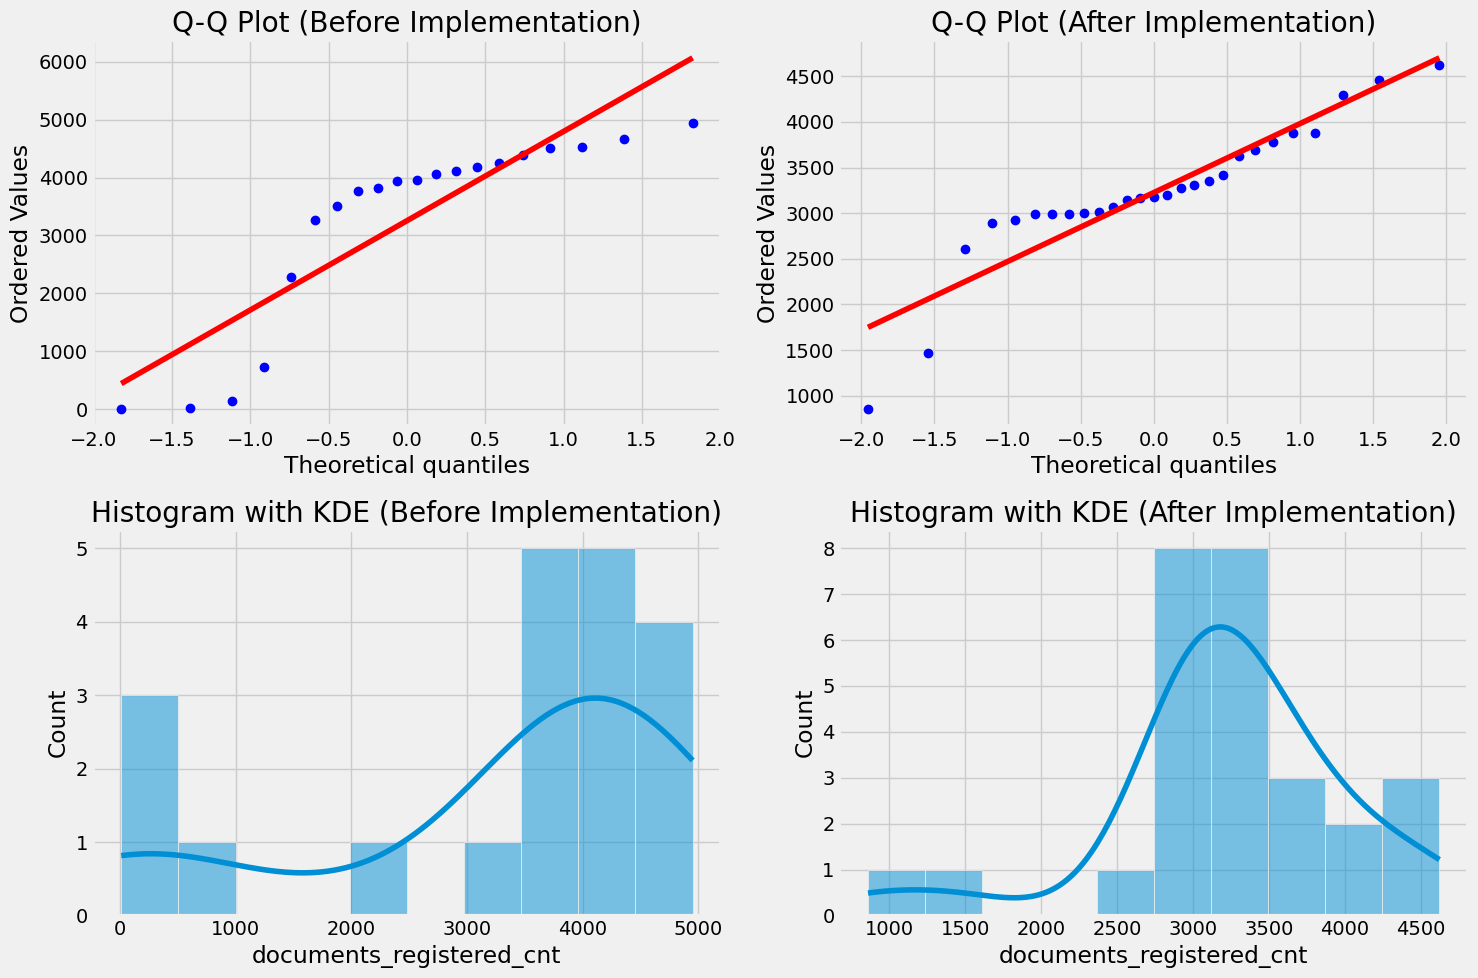

In [32]:
# Check normality for 'documents_registered_cnt' before implementation
stat_before, p_before = stats.shapiro(monthly_avg_before['documents_registered_cnt'])

# Check normality for 'documents_registered_cnt' after implementation
stat_after, p_after = stats.shapiro(monthly_avg_after['documents_registered_cnt'])

print(f"P-value for normality test (before implementation): {p_before}")
print(f"P-value for normality test (after implementation): {p_after}")

# Visualization
plt.figure(figsize=(15, 10))

# Q-Q Plot (Before Implementation)
plt.subplot(2, 2, 1)
stats.probplot(monthly_avg_before['documents_registered_cnt'], plot=plt)
plt.title("Q-Q Plot (Before Implementation)")

# Q-Q Plot (After Implementation)
plt.subplot(2, 2, 2)
stats.probplot(monthly_avg_after['documents_registered_cnt'], plot=plt)
plt.title("Q-Q Plot (After Implementation)")

# Histogram and KDE (Before Implementation)
plt.subplot(2, 2, 3)
sns.histplot(monthly_avg_before['documents_registered_cnt'], kde=True, bins=10)
plt.title("Histogram with KDE (Before Implementation)")

# Histogram and KDE (After Implementation)
plt.subplot(2, 2, 4)
sns.histplot(monthly_avg_after['documents_registered_cnt'], kde=True, bins=10)
plt.title("Histogram with KDE (After Implementation)")

plt.tight_layout()
plt.show()


In [35]:

# Conduct the Levene's test
stat, p_value = levene(monthly_avg_before['documents_registered_cnt'], monthly_avg_after['documents_registered_cnt'])

print(f"Levene's test statistic: {stat}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Variances are not equal between the two periods.")
else:
    print("Fail to reject the null hypothesis: Variances are approximately equal between the two periods.")

Levene's test statistic: 4.038009137290058
P-value: 0.05050611060552036
Fail to reject the null hypothesis: Variances are approximately equal between the two periods.


#### Hypotheses for the t-test on documents_registered_cnt

**Null Hypothesis (H0):**
The means of `documents_registered_cnt` are equal before and after the implementation of e-Stamp challan.

μ_before = μ_after

**Alternative Hypothesis (Ha):**
The means of `documents_registered_cnt` are not equal before and after the implementation of e-Stamp challan.

μ_before ≠ μ_after


In [36]:
# Conduct the independent two-sample t-test
t_stat, p_value = stats.ttest_ind(monthly_avg_before['documents_registered_cnt'], monthly_avg_after['documents_registered_cnt'], equal_var=True)

print(f"T-test statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The means of 'documents_registered_cnt' are significantly different before and after the implementation of e-Stamp challan.")
else:
    print("Fail to reject the null hypothesis: There's no significant difference in the means of 'documents_registered_cnt' before and after the implementation of e-Stamp challan.")

T-test statistic: 0.08198948946348772
P-value: 0.9350186757332981
Fail to reject the null hypothesis: There's no significant difference in the means of 'documents_registered_cnt' before and after the implementation of e-Stamp challan.


#### Hypotheses for the Mann-Whitney U test on documents_registered_cnt

**Null Hypothesis (H0):**
The distributions of `documents_registered_cnt` are the same for both periods.

**Alternative Hypothesis (Ha):**
The distributions of `documents_registered_cnt` are different between the two periods.


In [37]:
# Conduct the Mann-Whitney U test
u_stat, p_value = stats.mannwhitneyu(monthly_avg_before['documents_registered_cnt'], monthly_avg_after['documents_registered_cnt'], alternative='two-sided')

print(f"Mann-Whitney U statistic: {u_stat}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The distributions of 'documents_registered_cnt' are significantly different before and after the implementation of e-Stamp challan.")
else:
    print("Fail to reject the null hypothesis: There's no significant difference in the distributions of 'documents_registered_cnt' before and after the implementation of e-Stamp challan.")

Mann-Whitney U statistic: 354.0
P-value: 0.07239375239099241
Fail to reject the null hypothesis: There's no significant difference in the distributions of 'documents_registered_cnt' before and after the implementation of e-Stamp challan.


In [38]:
# Calculate the means and standard deviations
mean_before = monthly_avg_before['documents_registered_cnt'].mean()
std_before = monthly_avg_before['documents_registered_cnt'].std()

mean_after = monthly_avg_after['documents_registered_cnt'].mean()
std_after = monthly_avg_after['documents_registered_cnt'].std()

# Calculate the pooled standard deviation
n_before = len(monthly_avg_before)
n_after = len(monthly_avg_after)

pooled_std = np.sqrt(((n_before - 1) * std_before**2 + (n_after - 1) * std_after**2) / (n_before + n_after - 2))

# Calculate Cohen's d
cohens_d = (mean_before - mean_after) / pooled_std

print(f"Cohen's d: {cohens_d}")

Cohen's d: 0.02418857206358829


Cohen's d value of 0.0242 indicates a very small effect size. In simple terms, this means that the difference in the average number of documents registered before and after the implementation of e-Stamp challan is negligible and practically insignificant.






The statistical tests conducted on the documents_registered_cnt before and after the implementation of e-Stamp challan reveal no significant difference in their means or distributions. Both parametric (T-test) and non-parametric (Mann-Whitney U) tests support this conclusion. Additionally, the small effect size (Cohen's d value of 0.0242) suggests that the observed differences are practically insignificant. Thus, the implementation of e-Stamp challan has not notably impacted the average number of documents registered.

#### Granger Causality Test for e-Stamp Challan Implementation

**Definition:**
The Granger Causality Test determines if one time series can predict another. In this context, we're investigating if changes in e-Stamp challan counts (`estamps_challans_cnt`) can predict changes in document registration counts (`documents_registered_cnt`) after the implementation of e-Stamp challan.

**Formula:**
Given two time series `Y` (document registrations) and `X` (e-Stamp challans), `X` is said to Granger-cause `Y` if past values of `X` provide information about future values of `Y`.

Mathematically, we estimate two models:

1. Y = α + ∑(i=1 to n) βi * Y(t-i) + ϵt
2. Y = α + ∑(i=1 to n) βi * Y(t-i) + ∑(i=1 to n) γi * X(t-i) + ϵt

If the coefficients `γi` in the second model are statistically significant (typically checked using an F-test), then `X` Granger-causes `Y`.

**Application to Use Case:**
We'll apply the Granger Causality Test to the data after the e-Stamp challan implementation to determine if there's a causal relationship between e-Stamp challan counts and document registration counts during the period when both were active.

**Null Hypothesis (H0):**
The lagged values of the `estamps_challans_cnt` series do not Granger-cause the `documents_registered_cnt` series. In other words, past values of the `estamps_challans_cnt` series do not provide any information that helps predict the future values of the `documents_registered_cnt` series.

**Alternative Hypothesis (Ha):**
The lagged values of the `estamps_challans_cnt` series do Granger-cause the `documents_registered_cnt` series. This means that past values of the `estamps_challans_cnt` series provide information that can help predict the future values of the `documents_registered_cnt` series.

* Note: The same hypotheses can be framed in the reverse order to test if the documents_registered_cnt series Granger-causes the estamps_challans_cnt series.

In [39]:
after_impl_grouped = after_impl.groupby('month')[['documents_registered_cnt', 'estamps_challans_cnt']].mean().reset_index()

# Drop the 'month' column as it's not needed for the Granger test
data_for_granger = after_impl_grouped[['documents_registered_cnt', 'estamps_challans_cnt']]

# Perform the Granger Causality test
max_lag = 7  # You can adjust this based on your preference
granger_test_result = grangercausalitytests(data_for_granger, max_lag, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0764  , p=0.7848  , df_denom=23, df_num=1
ssr based chi2 test:   chi2=0.0863  , p=0.7689  , df=1
likelihood ratio test: chi2=0.0862  , p=0.7691  , df=1
parameter F test:         F=0.0764  , p=0.7848  , df_denom=23, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7104  , p=0.5034  , df_denom=20, df_num=2
ssr based chi2 test:   chi2=1.7761  , p=0.4115  , df=2
likelihood ratio test: chi2=1.7159  , p=0.4240  , df=2
parameter F test:         F=0.7104  , p=0.5034  , df_denom=20, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3494  , p=0.2917  , df_denom=17, df_num=3
ssr based chi2 test:   chi2=5.7150  , p=0.1263  , df=3
likelihood ratio test: chi2=5.1263  , p=0.1628  , df=3
parameter F test:         F=1.3494  , p=0.2917  , df_denom=17, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7796  , p=0.5567  , df_d

Conclusion:
The Granger Causality test results are mixed. For most lags, there's no evidence to suggest that past values of estamps_challans_cnt can predict the current month's documents_registered_cnt. However, for lags 5, 6, and 7, some tests indicate potential predictive power, while others do not.

Given these mixed results, it's challenging to conclusively state that changes in estamps_challans_cnt can predict changes in documents_registered_cnt. It might be beneficial to consider other factors or conduct further analyses to gain a clearer understanding of the relationship between these two variables.

### Correlation Analysis

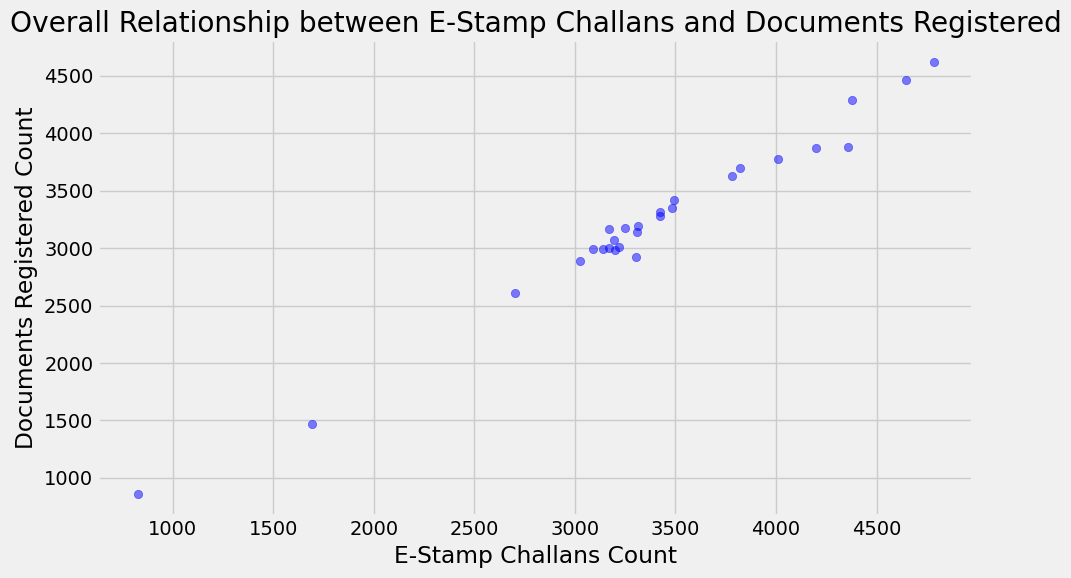

In [40]:
# Extract data for plotting
x = after_impl_grouped['estamps_challans_cnt']
y = after_impl_grouped['documents_registered_cnt']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', alpha=0.5)
plt.title("Overall Relationship between E-Stamp Challans and Documents Registered")
plt.xlabel("E-Stamp Challans Count")
plt.ylabel("Documents Registered Count")
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

Pearson correlation coefficient

In [41]:
# Extract data for correlation
x = after_impl_grouped['estamps_challans_cnt']
y = after_impl_grouped['documents_registered_cnt']

# Compute the Pearson correlation coefficient
correlation_coefficient = np.corrcoef(x, y)[0, 1]

print(f"Pearson Correlation Coefficient: {correlation_coefficient:.3f}")

Pearson Correlation Coefficient: 0.992


The Pearson Correlation Coefficient of approximately 
0.992
0.992 between e-Stamp challans count and documents registered count indicates a remarkably strong positive linear relationship. This suggests that an increase in e-Stamp challan usage is closely associated with a proportional rise in document registrations.

## E-Stamp Challan Implementation Impact Report

### Introduction

The e-Stamp challan system was introduced by the government on December 1, 2020, with the primary objective of simplifying the document registration process. This report delves into the effects of this system on the counts of e-Stamp challans and document registrations.

### Key Observations

1. **Seasonality and Trends:**
   - The data showcases a recurring pattern, with noticeable peaks at the onset of each year, especially during December and January. This surge is typically followed by a dip around the middle of the year.
   - A noteworthy decline in both e-Stamp challans and document registrations was observed in May 2021. This could be attributed to external events or factors that momentarily impacted both metrics.
   - The data doesn't display a pronounced upward or downward trajectory over the entire period, indicating a stable trend in the metrics.

2. **Data Gaps:**
   - A data void for September 2021 was identified. This could stem from challenges in data gathering or potential entry errors.

3. **Post-Implementation Analysis:**
   - After the e-Stamp system's rollout, its adoption saw a gradual uptick. The rise was steady rather than immediate.
   - In the subsequent year, 2022, the e-Stamp count marginally surpassed document registrations for most months.
   - While the monthly average of document registrations across districts saw a slight dip post-implementation, the combined count of both metrics exhibited significant growth, marking a 75% increase in the total count.

4. **Yearly and Quarterly Growth:**
   - A growth trajectory was discerned from 2021 to 2022.
   - Fiscal year data analysis revealed a consistent growth pattern from Q3 to Q4, suggesting that the majority of document registrations transpire in the fourth quarter.

5. **Statistical Analysis:**
   - Levene's test indicated that the variances between the two periods are roughly equal.
   - The Granger Causality test yielded mixed outcomes. While most lags didn't show evidence that past values of e-Stamp challans could predict the current month's document registrations, lags 5, 6, and 7 exhibited potential predictive capabilities.
   - A Pearson Correlation Coefficient of approximately 0.992 between e-Stamp challans count and document registrations signifies a robust positive linear relationship. This suggests that as e-Stamp adoption grows, document registrations also increase in tandem.

### Conclusion

The e-Stamp challan system's introduction has positively influenced document registrations. While there's a robust linear relationship between the two metrics, it's crucial to factor in other external elements that might sway these numbers. The government should persistently track these trends and consider in-depth analyses to better comprehend the relationship. The consistent growth observed in the fourth quarter each fiscal year implies that promotional or awareness drives during this period might further amplify registrations.

### Recommendations for the Government

1. **Data Integrity:** Investigate the data void in September 2021 to ensure the accuracy and reliability of the data.
2. **Promotion of E-Stamp System:** Given the robust correlation between e-Stamp adoption and document registrations, the government should contemplate promoting the e-Stamp system more aggressively, especially during peak registration periods.
3. **Integration:** The government could mull over further amalgamating the e-Stamp system with document registration, given their strong correlation. This could simplify the process and enhance user experience.
4. **Public Awareness:** Launch public awareness campaigns, especially targeting rural areas, to educate the masses about the benefits and ease of using e-Stamp challans.
5. **Expand E-stamping Services:** Consider expanding e-stamping services to other domains, making it more versatile and comprehensive.
6. **Integration with Other Services:** Meld e-stamping with other governmental services, like property registration, to offer a seamless experience to users.
7. **Analyze Underperforming Districts:** Conduct a thorough analysis of districts that have shown less enthusiasm towards the e-Stamp service. Understand the challenges and work towards addressing them.
8. **Continuous Monitoring:** While the current data doesn't show a significant decline in document registrations post e-Stamp implementation, it's vital to keep a close watch on the trends to address any future declines promptly.

By implementing these recommendations, the government can ensure that the e-Stamp system continues to benefit the public and contributes positively to the administrative processes.


# Problem Statement 3
# Categorize districts into three segments based on their stamp registration revenue generation during the fiscal year 2021 to 2022.

In [57]:
# Filter data in the 'stamps' DataFrame for fiscal year 2021 to 2022
filtered_stamps = stamps[stamps['fiscal_year'].isin([2021,2022])]

# Select required columns and group by district
# Group by 'district' and sum the required columns
grouped = filtered_stamps.groupby('district').agg({
    'documents_registered_rev': 'sum',
    'estamps_challans_rev': 'sum'
}).reset_index()
# Calculate the sum of both revenues
grouped['total_revenue'] = grouped['documents_registered_rev'] + grouped['estamps_challans_rev']

grouped.head()

,district,documents_registered_rev,estamps_challans_rev,total_revenue
0,Adilabad,7.209264e+08,7.230031e+08,1.443929e+09
1,Bhadradri Kothagudem,5.341809e+08,5.407226e+08,1.074903e+09
2,Hanumakonda,4.895047e+09,4.959670e+09,9.854717e+09
3,Hyderabad,2.497790e+10,2.526799e+10,5.024590e+10
4,Jagtial,1.069527e+09,1.079332e+09,2.148859e+09


In [58]:
grouped.describe()

,documents_registered_rev,estamps_challans_rev,total_revenue
count,3.200000e+01,3.200000e+01,3.200000e+01
mean,5.961606e+09,6.025475e+09,1.198708e+10
std,1.438746e+10,1.456796e+10,2.895528e+10
min,1.362573e+08,1.334203e+08,2.696776e+08
25%,7.054438e+08,7.088953e+08,1.414339e+09
50%,1.078032e+09,1.092658e+09,2.170690e+09
75%,2.599319e+09,2.619492e+09,5.218810e+09
max,6.956323e+10,7.068230e+10,1.402455e+11


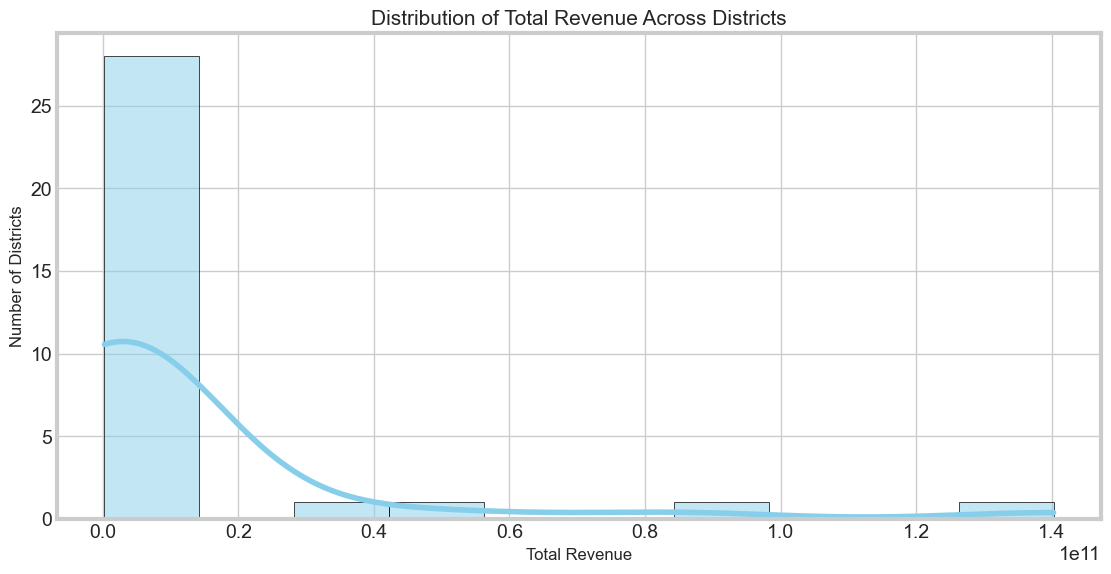

In [68]:
# Set the style for seaborn
sns.set_style("whitegrid")

# Initialize the figure
plt.figure(figsize=(12, 6))

# Plotting the histogram and KDE plot
sns.histplot(grouped['total_revenue'], kde=True, bins=10, color='skyblue', edgecolor='black')

# Setting the title and labels
plt.title('Distribution of Total Revenue Across Districts', fontsize=15)
plt.xlabel('Total Revenue', fontsize=12)
plt.ylabel('Number of Districts', fontsize=12)

# Display the plot
plt.show()

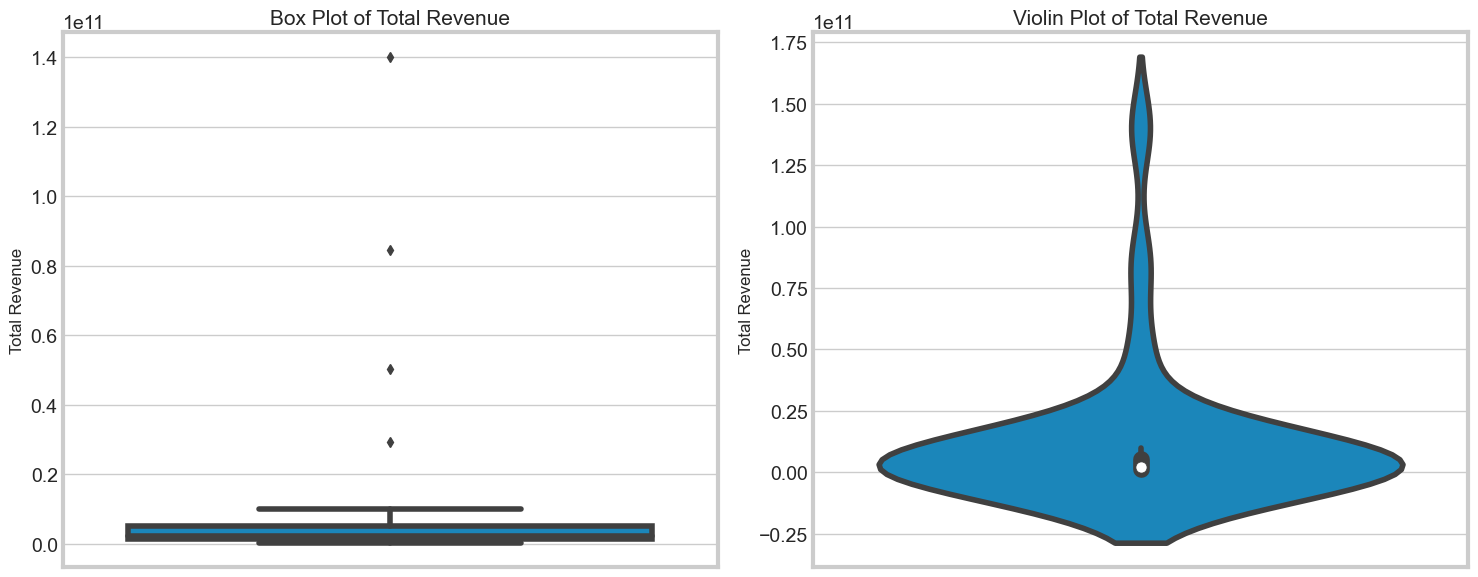

In [64]:
# Set the style for seaborn
sns.set_style("whitegrid")

# Initialize the figure
plt.figure(figsize=(15, 6))

# Create a subplot for Box Plot
plt.subplot(1, 2, 1)
sns.boxplot(y=grouped['total_revenue'])
plt.title('Box Plot of Total Revenue', fontsize=15)
plt.ylabel('Total Revenue', fontsize=12)

# Create a subplot for Violin Plot
plt.subplot(1, 2, 2)
sns.violinplot(y=grouped['total_revenue'])
plt.title('Violin Plot of Total Revenue', fontsize=15)
plt.ylabel('Total Revenue', fontsize=12)

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

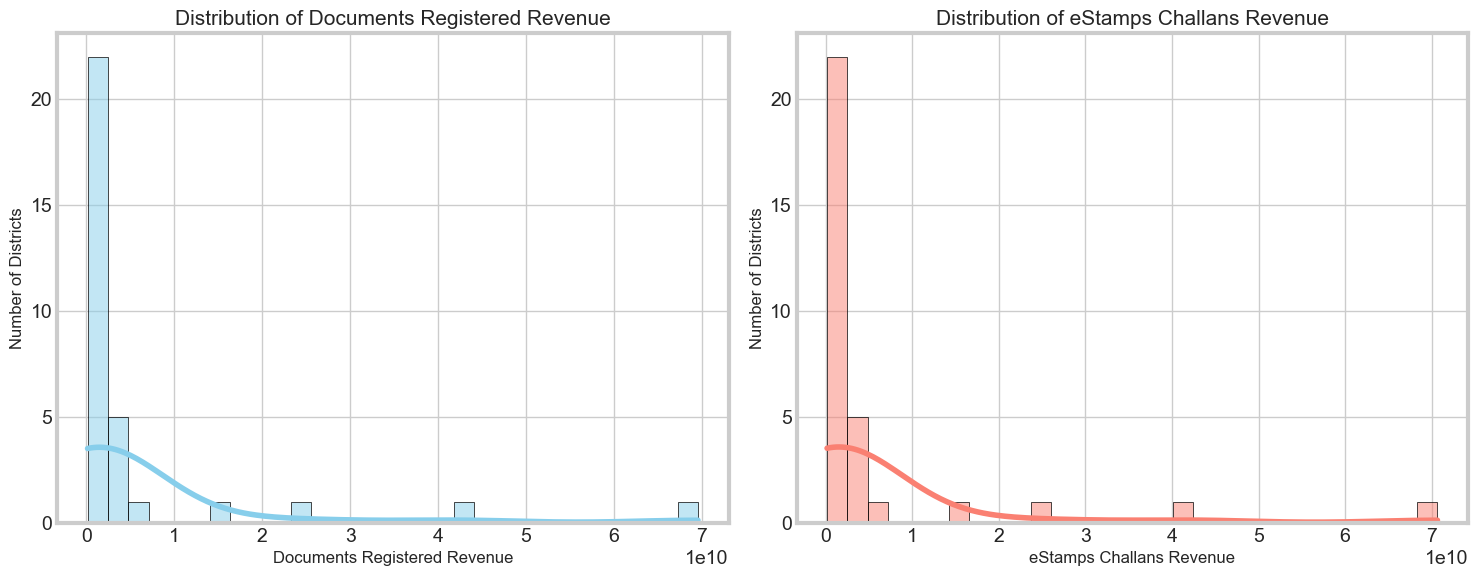

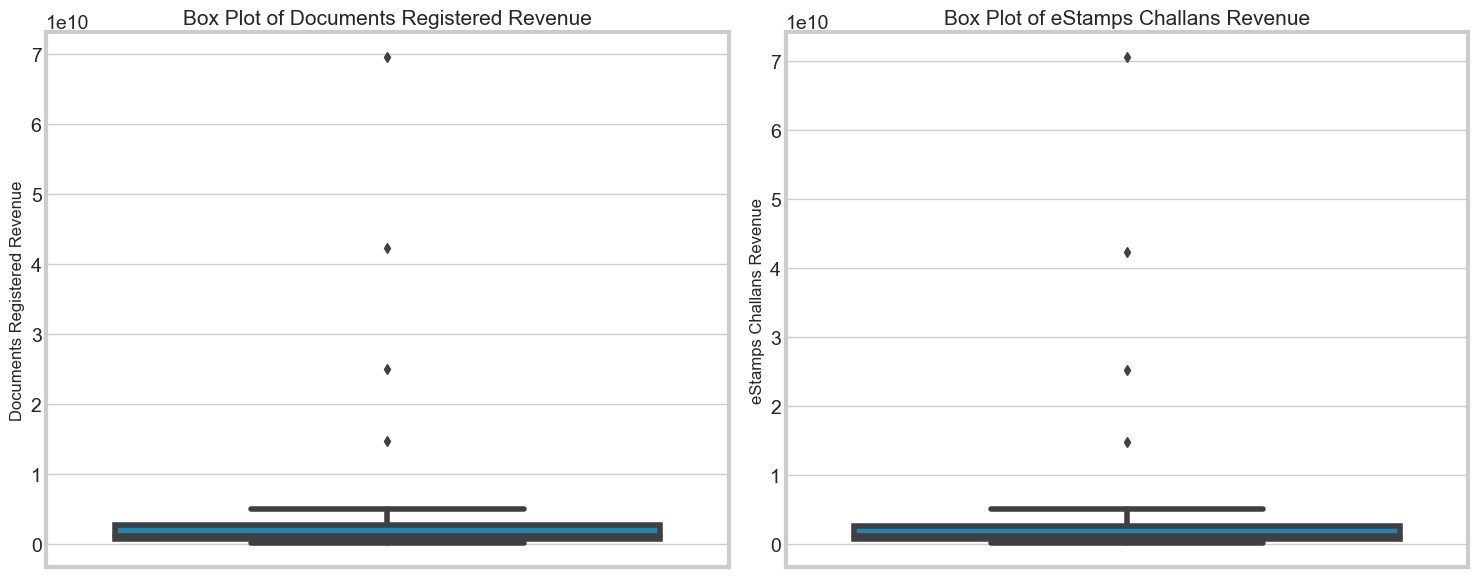

In [65]:
# Set the style for seaborn
sns.set_style("whitegrid")

# Initialize the figure for histograms with KDE
plt.figure(figsize=(15, 6))

# Histogram with KDE for documents_registered_rev
plt.subplot(1, 2, 1)
sns.histplot(grouped['documents_registered_rev'], kde=True, bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Documents Registered Revenue', fontsize=15)
plt.xlabel('Documents Registered Revenue', fontsize=12)
plt.ylabel('Number of Districts', fontsize=12)

# Histogram with KDE for estamps_challans_rev
plt.subplot(1, 2, 2)
sns.histplot(grouped['estamps_challans_rev'], kde=True, bins=10, color='salmon', edgecolor='black')
plt.title('Distribution of eStamps Challans Revenue', fontsize=15)
plt.xlabel('eStamps Challans Revenue', fontsize=12)
plt.ylabel('Number of Districts', fontsize=12)

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

# Initialize the figure for box plots
plt.figure(figsize=(15, 6))

# Box plot for documents_registered_rev
plt.subplot(1, 2, 1)
sns.boxplot(y=grouped['documents_registered_rev'])
plt.title('Box Plot of Documents Registered Revenue', fontsize=15)
plt.ylabel('Documents Registered Revenue', fontsize=12)

# Box plot for estamps_challans_rev
plt.subplot(1, 2, 2)
sns.boxplot(y=grouped['estamps_challans_rev'])
plt.title('Box Plot of eStamps Challans Revenue', fontsize=15)
plt.ylabel('eStamps Challans Revenue', fontsize=12)

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

#### first approch
Segmentation Criteria Definition:

High Revenue Districts: Districts generating revenue above a certain percentile (e.g., above the 75th percentile).

Medium Revenue Districts: Districts generating revenue between two percentiles (e.g., between the 25th and 75th percentile).

Low Revenue Districts: Districts generating revenue below a certain percentile (e.g., below the 25th percentile).

In [69]:
# Calculate the 25th and 75th percentiles of total_revenue
p25 = grouped['total_revenue'].quantile(0.25)
p75 = grouped['total_revenue'].quantile(0.75)

# Define a function to categorize districts based on the segmentation criteria
def categorize_revenue(row):
    if row['total_revenue'] > p75:
        return 'High Revenue District'
    elif p25 <= row['total_revenue'] <= p75:
        return 'Medium Revenue District'
    else:
        return 'Low Revenue District'

# Apply the function to the dataframe to create a new column 'revenue_category'
grouped['revenue_category'] = grouped.apply(categorize_revenue, axis=1)

# Display the categorized districts
print(grouped[['district', 'total_revenue', 'revenue_category']])

                 district  total_revenue         revenue_category
0                Adilabad   1.443929e+09  Medium Revenue District
1    Bhadradri Kothagudem   1.074903e+09     Low Revenue District
2             Hanumakonda   9.854717e+09    High Revenue District
3               Hyderabad   5.024590e+10    High Revenue District
4                 Jagtial   2.148859e+09  Medium Revenue District
5                 Jangoan   1.481043e+09  Medium Revenue District
6        Jogulamba Gadwal   1.205641e+09     Low Revenue District
7               Kamareddy   1.711241e+09  Medium Revenue District
8              Karimnagar   5.253082e+09    High Revenue District
9                 Khammam   7.262014e+09    High Revenue District
10  Kumurambheem Asifabad   2.696776e+08     Low Revenue District
11            Mahabubabad   1.325568e+09     Low Revenue District
12           Mahabubnagar   3.941383e+09  Medium Revenue District
13             Mancherial   2.192522e+09  Medium Revenue District
14        

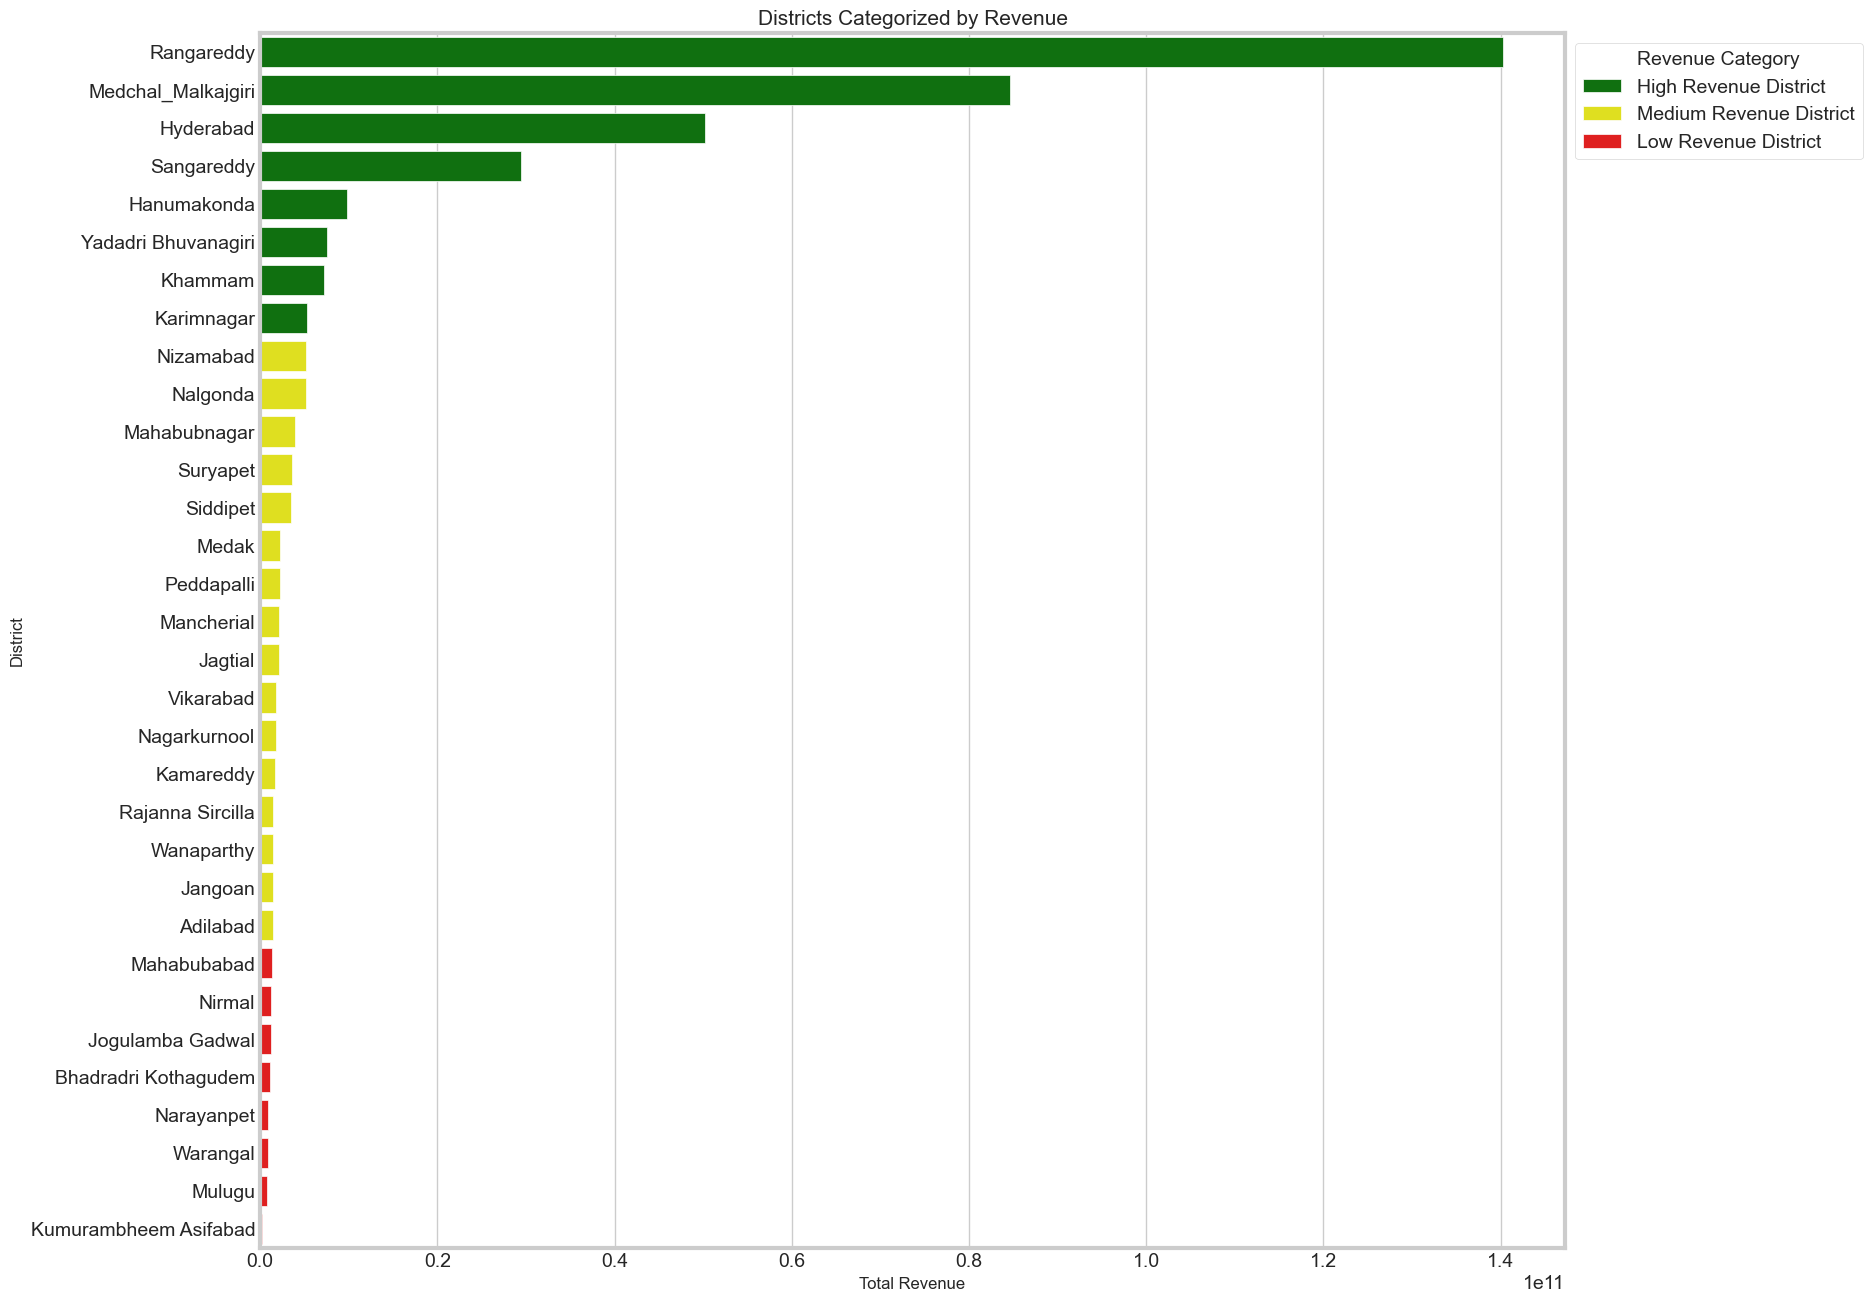

In [72]:
# Set the style for seaborn
sns.set_style("whitegrid")

# Initialize the figure
plt.figure(figsize=(15, 15))

# Create a sorted bar plot
sorted_data = grouped.sort_values(by='total_revenue', ascending=False)
palette = {"High Revenue District": "green", "Medium Revenue District": "yellow", "Low Revenue District": "red"}
sns.barplot(x='total_revenue', y='district', data=sorted_data, hue='revenue_category', dodge=False, palette=palette)

# Setting the title and labels
plt.title('Districts Categorized by Revenue', fontsize=15)
plt.xlabel('Total Revenue', fontsize=12)
plt.ylabel('District', fontsize=12)
plt.legend(title='Revenue Category', loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()

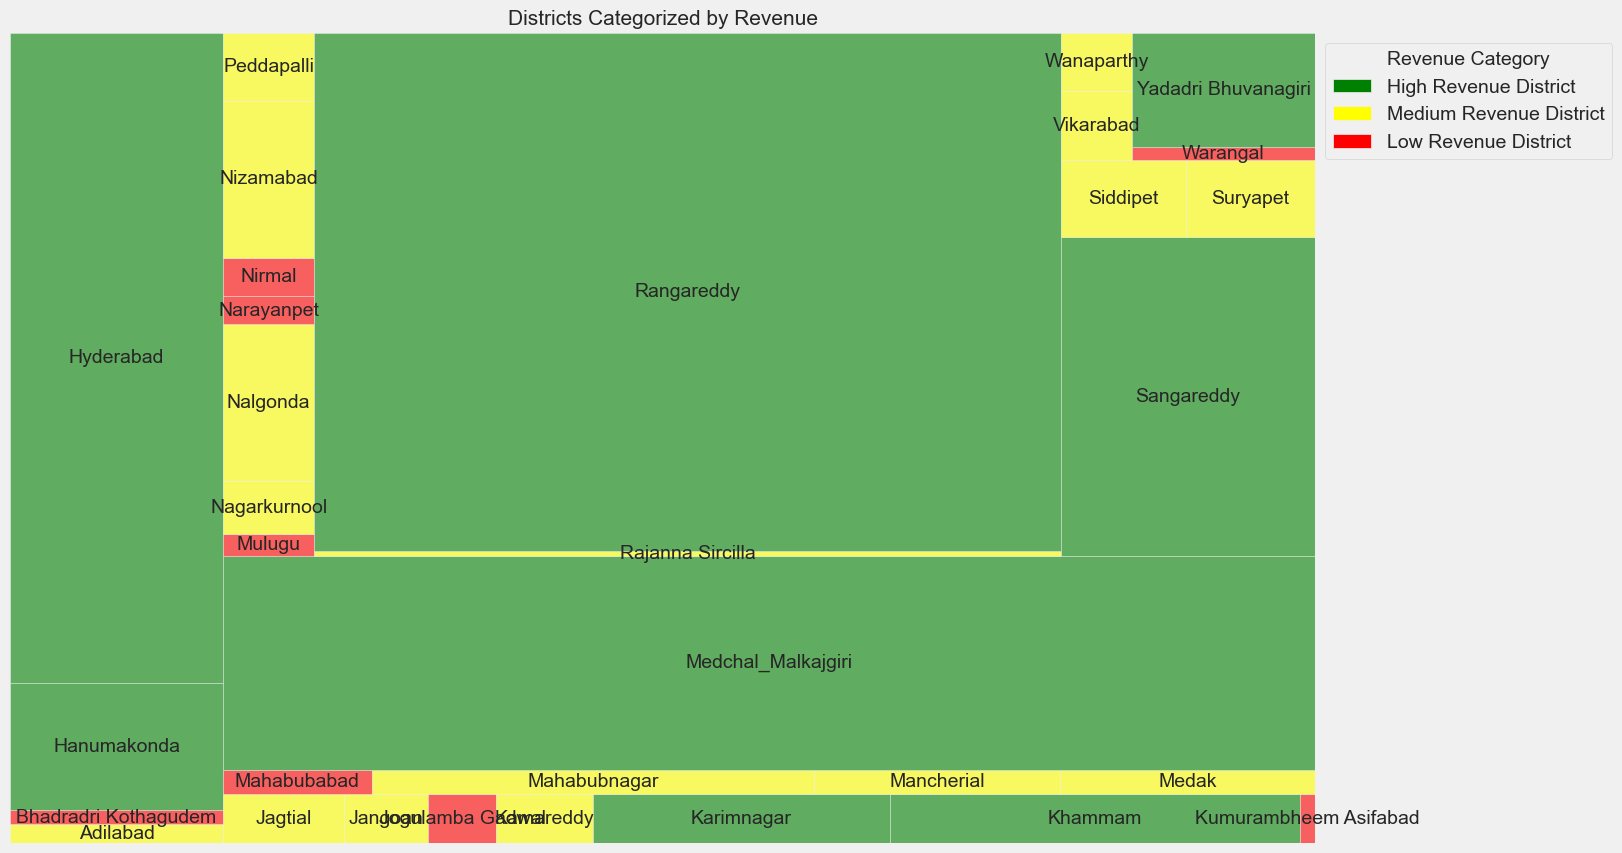

In [77]:
# Define a color map for the revenue categories
color_map = {
    "High Revenue District": "green",
    "Medium Revenue District": "yellow",
    "Low Revenue District": "red"
}

# Extract colors based on 'revenue_category'
colors = grouped['revenue_category'].map(color_map).tolist()

# Create a treemap
plt.figure(figsize=(15, 10))
squarify.plot(sizes=grouped['total_revenue'], label=grouped['district'], color=colors, alpha=0.6)

# Setting the title
plt.title('Districts Categorized by Revenue', fontsize=15)
plt.axis('off')  # Turn off the axis

# Create a custom legend
from matplotlib.patches import Patch
legend_labels = [Patch(facecolor=color_map[key], label=key) for key in color_map]
plt.legend(handles=legend_labels, title='Revenue Category', loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()

In [78]:
# Aggregate the total revenue for each category
revenue_by_category = grouped.groupby('revenue_category')['total_revenue'].sum().reset_index()

# Create the donut plot
fig = go.Figure(data=[go.Pie(labels=revenue_by_category['revenue_category'],
                             values=revenue_by_category['total_revenue'],
                             hole=.3,  # This creates the 'donut' shape
                             pull=[0.1, 0.1, 0.1],  # This 'pulls' each section out a bit for better visibility
                             )])

# Set the title
fig.update_layout(title_text="Share of Total Revenue by Category")

# Display the plot
fig.show()

In [79]:
revenue_by_category

,revenue_category,total_revenue
0,High Revenue District,3.344383e+11
1,Low Revenue District,7.665200e+09
2,Medium Revenue District,4.148310e+10


In [114]:
# Load the GeoJSON data
map_file = (r"D:\Telangana_Growth_Analysis\Telangana_Shape_Files\telangana_district_map.json")
geo_data = gpd.read_file(map_file)

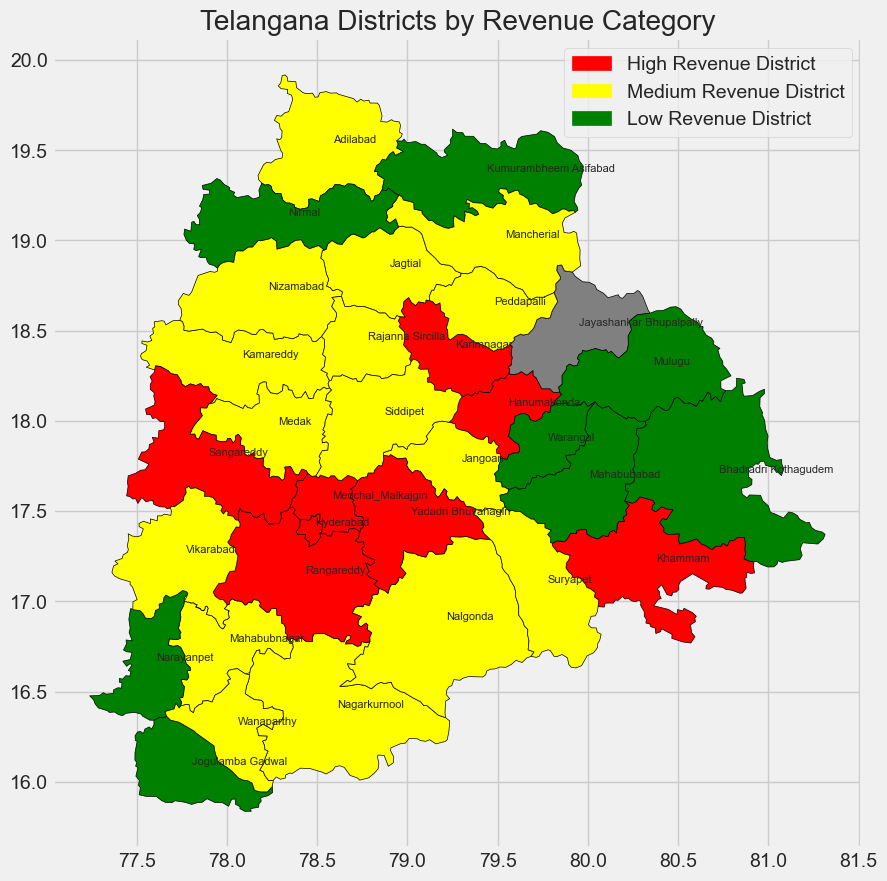

In [105]:

def visualize_district_data(geo_data, data_dict):
    # Define a color map for the revenue categories
    color_map = {
        'High Revenue District': 'red',
        'Medium Revenue District': 'yellow',
        'Low Revenue District': 'green'
    }
    
    # Map the district names to their corresponding colors
    geo_data['color'] = geo_data['Dist_Name'].map(lambda x: color_map.get(data_dict.get(x, 'grey'), 'grey'))
    
    # Plot the map
    fig, ax = plt.subplots(figsize=(10, 10))
    geo_data.plot(ax=ax, edgecolor="k", facecolor=geo_data['color'])
    
    # Annotate district names
    for x, y, label in zip(geo_data.geometry.centroid.x, geo_data.geometry.centroid.y, geo_data['Dist_Name']):
        ax.annotate(label, xy=(x, y), xytext=(3,3), textcoords="offset points", fontsize=8)
    
    # Create a legend
    high_patch = mpatches.Patch(color='red', label='High Revenue District')
    medium_patch = mpatches.Patch(color='yellow', label='Medium Revenue District')
    low_patch = mpatches.Patch(color='green', label='Low Revenue District')
    ax.legend(handles=[high_patch, medium_patch, low_patch], loc='upper right')
    
    ax.set_title("Telangana Districts by Revenue Category")
    plt.show()

# Use the function
geo_data = gpd.read_file(map_file)
visualize_district_data(geo_data, data_dict)

In [113]:

def visualize_district_data_interactive(geo_data, data_dict, revenue_dict):
    # Define a color map for the revenue categories
    color_map = {
        'High Revenue District': 'red',
        'Medium Revenue District': 'yellow',
        'Low Revenue District': 'green'
    }
    
    # Map the district names to their corresponding colors
    geo_data['color'] = geo_data['Dist_Name'].map(lambda x: color_map.get(data_dict.get(x, 'grey'), 'grey'))
    
    # Create a base map
    m = folium.Map(location=[geo_data.geometry.centroid.y.mean(), geo_data.geometry.centroid.x.mean()], zoom_start=7)
    
    # Add the district polygons to the map
    for _, row in geo_data.iterrows():
        district_name = row['Dist_Name']
        revenue = revenue_dict.get(district_name, "N/A")
        popup_content = f"District: {district_name}<br>Total Revenue: {revenue}"
        
        folium.GeoJson(
            row['geometry'],
            name=district_name,
            style_function=lambda feature, color=row['color']: {
                'fillColor': color,
                'color': 'black',
                'weight': 1,
                'fillOpacity': 0.7
            }
        ).add_child(folium.Popup(popup_content)).add_to(m)
        
         # Add a custom legend
    legend_html = """
    <div style="position: fixed; bottom: 50px; left: 50px; width: 150px; height: 90px; background-color: white; border:2px solid grey; z-index:9999; font-size:14px;">
    &nbsp;<b>Revenue Category:</b><br>
    &nbsp;<i class="fa fa-square fa-1x" style="color:red"></i>&nbsp;High<br>
    &nbsp;<i class="fa fa-square fa-1x" style="color:yellow"></i>&nbsp;Medium<br>
    &nbsp;<i class="fa fa-square fa-1x" style="color:green"></i>&nbsp;Low<br>
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))

    
    return m


# Convert the 'district' and 'total_revenue' columns to a dictionary
revenue_dict = grouped.set_index('district')['total_revenue'].to_dict()


# Use the function
geo_data = gpd.read_file(map_file)
visualize_district_data_interactive(geo_data, data_dict, revenue_dict)


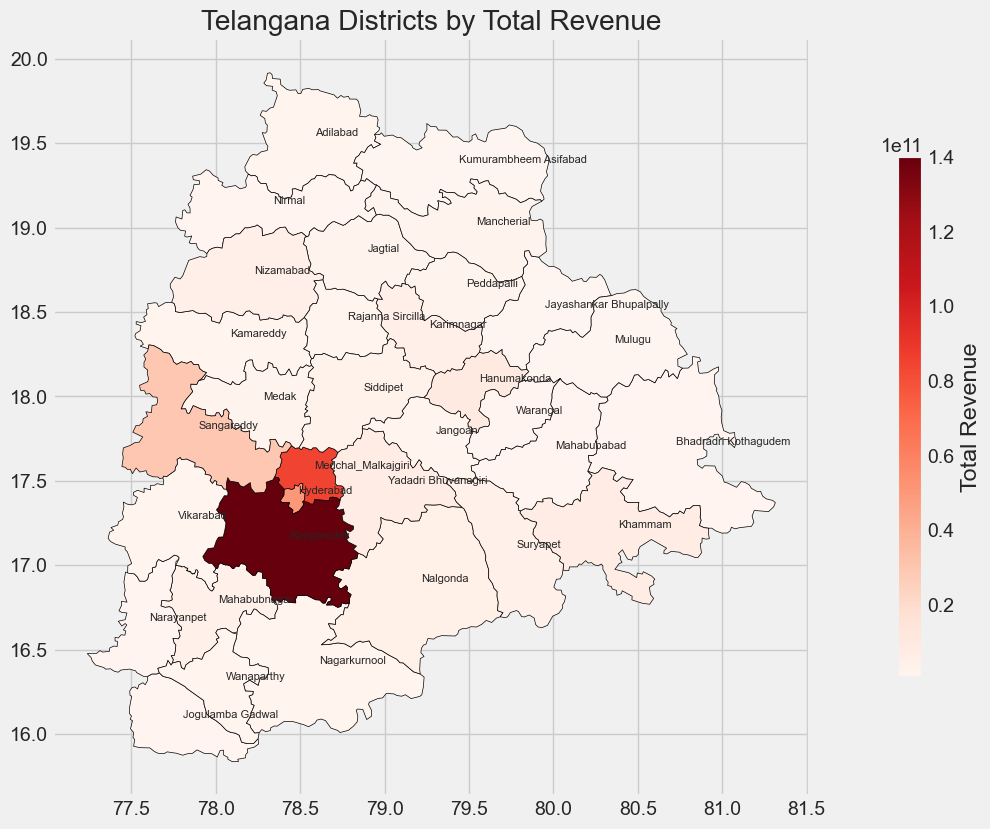

In [120]:
def visualize_district_data(geo_data, data_dict, revenue_dict):
    # Normalize the total revenue values
    norm = mcolors.Normalize(vmin=min(revenue_dict.values()), vmax=max(revenue_dict.values()))
    
    # Map the district names to their corresponding colors based on total revenue
    geo_data['color'] = geo_data['Dist_Name'].map(lambda x: plt.cm.Reds(norm(revenue_dict.get(x, 0))))
    
    # Plot the map
    fig, ax = plt.subplots(figsize=(10, 10))
    geo_data.plot(ax=ax, edgecolor="k", facecolor=geo_data['color'])
    
    # Annotate district names
    for x, y, label in zip(geo_data.geometry.centroid.x, geo_data.geometry.centroid.y, geo_data['Dist_Name']):
        ax.annotate(label, xy=(x, y), xytext=(3,3), textcoords="offset points", fontsize=8)
    
    # Add a colorbar to the plot
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.1)
    cbar.set_label('Total Revenue')
    
    ax.set_title("Telangana Districts by Total Revenue")
    plt.show()

# Use the function
geo_data = gpd.read_file(map_file)
visualize_district_data(geo_data, data_dict, revenue_dict)

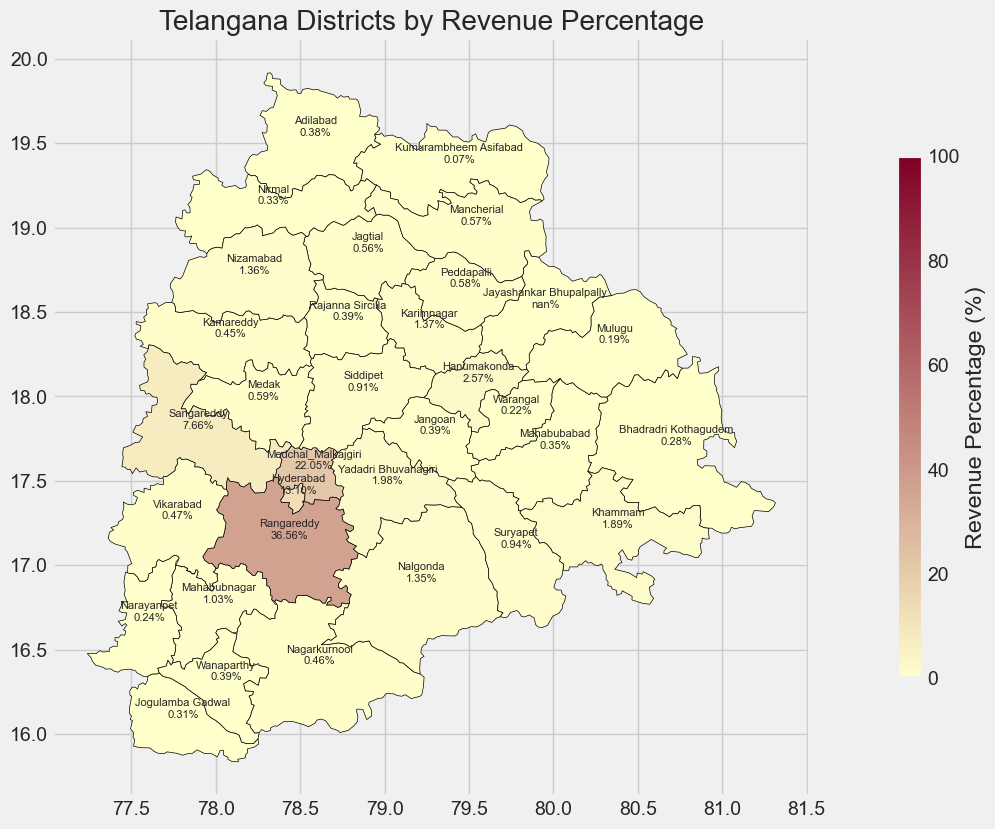

In [123]:
def visualize_district_percentage(geo_data, grouped):
    # Calculate the total revenue for all districts
    total_revenue_all = grouped['total_revenue'].sum()
    
    # Calculate the percentage of revenue for each district
    grouped['revenue_percentage'] = (grouped['total_revenue'] / total_revenue_all) * 100
    
    # Create a dictionary mapping district names to their revenue percentages
    percentage_dict = dict(zip(grouped['district'], grouped['revenue_percentage']))
    
    # Create a custom colormap
    cmap = mcolors.LinearSegmentedColormap.from_list("custom", ["#FFFFCC", "#800026"])
    
    # Normalize the revenue percentages
    norm = mcolors.Normalize(vmin=0, vmax=100)
    
    # Map the district names to their corresponding colors based on revenue percentage
    geo_data['color'] = geo_data['Dist_Name'].map(lambda x: cmap(norm(percentage_dict.get(x, 0))))
    
    # Plot the map
    fig, ax = plt.subplots(figsize=(10, 10))
    geo_data.plot(ax=ax, edgecolor="k", facecolor=geo_data['color'])
    
    # Annotate district names and their revenue percentages
    for x, y, label, percentage in zip(geo_data.geometry.centroid.x, geo_data.geometry.centroid.y, geo_data['Dist_Name'], geo_data['Dist_Name'].map(percentage_dict)):
        ax.annotate(f"{label}\n{percentage:.2f}%", xy=(x, y), xytext=(3,3), textcoords="offset points", fontsize=8, ha='center')
    
    # Add a colorbar to the plot
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.1)
    cbar.set_label('Revenue Percentage (%)')
    
    ax.set_title("Telangana Districts by Revenue Percentage")
    plt.show()

# Use the function
geo_data = gpd.read_file(map_file)
visualize_district_percentage(geo_data, grouped)

### Approch 2
Kmeans Clustering

In [130]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans

# Extract necessary columns
df = grouped[['district', 'documents_registered_rev', 'estamps_challans_rev', 'total_revenue']]

# Encode the 'district' column
label_encoder = LabelEncoder()
df['district_encoded'] = label_encoder.fit_transform(df['district'])

# Standardize the data
features = ['district_encoded', 'documents_registered_rev', 'estamps_challans_rev', 'total_revenue']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Apply k-means++ clustering
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# After clustering
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Reassign the original district names
df['district'] = label_encoder.inverse_transform(df['district_encoded'])

# Drop the encoded district column as it's no longer needed
df = df.drop('district_encoded', axis=1)

df.head()


,district,documents_registered_rev,estamps_challans_rev,total_revenue,Cluster
0,Adilabad,7.209264e+08,7.230031e+08,1.443929e+09,2
1,Bhadradri Kothagudem,5.341809e+08,5.407226e+08,1.074903e+09,2
2,Hanumakonda,4.895047e+09,4.959670e+09,9.854717e+09,2
3,Hyderabad,2.497790e+10,2.526799e+10,5.024590e+10,2
4,Jagtial,1.069527e+09,1.079332e+09,2.148859e+09,2


In [134]:
df

,district,documents_registered_rev,estamps_challans_rev,total_revenue,Cluster
0,Adilabad,7.209264e+08,7.230031e+08,1.443929e+09,2
1,Bhadradri Kothagudem,5.341809e+08,5.407226e+08,1.074903e+09,2
2,Hanumakonda,4.895047e+09,4.959670e+09,9.854717e+09,2
3,Hyderabad,2.497790e+10,2.526799e+10,5.024590e+10,2
4,Jagtial,1.069527e+09,1.079332e+09,2.148859e+09,2
5,Jangoan,7.336136e+08,7.474290e+08,1.481043e+09,2
6,Jogulamba Gadwal,6.016452e+08,6.039960e+08,1.205641e+09,2
7,Kamareddy,8.515788e+08,8.596620e+08,1.711241e+09,2
8,Karimnagar,2.619104e+09,2.633978e+09,5.253082e+09,2
9,Khammam,3.615170e+09,3.646845e+09,7.262014e+09,2


## District Segmentation Based on Stamp Registration Revenue (FY 2021-2022)

## Introduction
The revenue generated from stamp registration, which includes both document registration and e-stamp challans, plays a crucial role in the state's economy. This report categorizes districts into three segments based on their combined revenue generation during the fiscal year 2021 to 2022.

## Segmentation Criteria Definition
- **High Revenue Districts:** Districts generating revenue above the 75th percentile.
- **Medium Revenue Districts:** Districts generating revenue between the 25th and 75th percentile.
- **Low Revenue Districts:** Districts generating revenue below the 25th percentile.

## Analysis

### High Revenue Districts
**Districts:** Rangareddy, Medchal_Malkajgiri, Hyderabad, Sangareddy, Yadadri Bhuvanagiri, Hanumakonda, Khammam, and Karimnagar.

High Revenue Districts are primarily urbanized areas with a dense population, rapid development in IT, and other industries. The construction sector in these districts has been a significant contributor, accounting for 87.2% of the revenue in 2021-2022. Districts such as Rangareddy, Medchal, Hyderabad, Sangareddy, and Yadadri surround the capital city and have witnessed substantial growth. Tier 2 cities like Hanamkonda, Khammam, and Karimnagar have also seen urban development. A notable addition to this list is Yadadri, which has seen growth due to the development of the Yadadri temple. Many individuals from Hyderabad invest in land here, viewing it as a promising future investment. The total revenue generated by High Revenue Districts is approximately 334,438.3 million.

### Medium Revenue Districts
**Districts:** Adilabad, Jagtial, Jangoan, Kamareddy, Mahabubnagar, Mancherial, Medak, Nagarkurnool, Nalgonda, Nizamabad, Peddapalli, Rajanna Sircilla, Siddipet, Suryapet, Vikarabad, and Wanaparthy.

These districts are predominantly rural, with agriculture being the primary source of income for most residents. The revenue here is generated mainly from land transactions, which are fewer compared to urban areas. The presence of forests, natural resources, and government-owned land also plays a role in the revenue dynamics. These districts contributed 10.8% of the total revenue in 2021-2022. These districts contributed to a revenue of approximately 41,483.1 million.

### Low Revenue Districts
**Districts:** Bhadradri Kothagudem, Jogulamba Gadwal, Kumurambheem Asifabad, Mahabubabad, Mulugu, Narayanpet, Nirmal, and Warangal.

These districts, such as Bhadradri Kothagudem, have vast forest areas and are rich in natural resources. Low Revenue Districts are characterized by vast forest areas and natural resources. The population density is low, and the majority of the residents rely on agriculture. Due to the lesser population and fewer developed cities or industries, the number of transactions is limited These districts contributed a mere 2% to the total revenue in 2021-2022, which is approximately 766.5 million.

## Key Insights
- **Rangareddy District:** This district alone contributes a whopping 36.56% of the revenue, highlighting its significance in the state's economy.
- **Hyderabad:** The capital city follows closely, contributing 13.10% to the revenue.
- **Medchal Malkajgiri:** Another major contributor with a share of 22.05%.

### KMeans++ Clustering Analysis
An attempt was made to segment the districts using the KMeans++ clustering algorithm. However, the results were not as prominent as expected. This could be due to the inherent distribution of the data or the need for further feature engineering and optimization.

## Conclusion
The revenue generation analysis provides valuable insights into the economic dynamics of the districts. While urbanized areas contribute significantly to the revenue, the potential in rural districts remains largely untapped. Strategic development initiatives and investments in these areas can lead to a more balanced economic growth across the state.

## Recommendations

### Infrastructure Development
Enhance infrastructure in Medium and Low Revenue Districts to attract businesses and boost revenue.

### Promote Agriculture
With many districts having an agricultural base, introducing modern farming techniques and providing subsidies can enhance productivity and revenue.

### Tourism Development
Districts rich in natural resources and forests, especially those in the Low Revenue category, can be developed as tourist spots, generating additional revenue.

### Awareness Campaigns
Conduct awareness campaigns in Medium and Low Revenue Districts about the benefits of e-stamp challans and document registration to increase transactions.

This report emphasizes the need for a balanced economic
